⭐⭐⭐

# License

This notebook is licensed under the [Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License](https://creativecommons.org/licenses/by-nc-nd/4.0/).

You may view and share this work with attribution for non-commercial purposes only. Modification, commercial use, or redistribution of altered versions is strictly prohibited.


# SMS Spam Detection 

<!-- Signature: Jyoshika Barathimogan -->

# Introduction

This notebook focuses on the exploratory data analysis (EDA) phase of the SMS spam dataset. In this phase, we aim to:
- Inspect the raw data and understand its structure.
- Explore label distribution.
- Analyze message lengths, word frequencies, and Semantic Similarity Graph.
- Gather insights that will guide further text preprocessing and model-building steps.

# Importing pacakges

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.utils import resample
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim import corpora
from textblob import TextBlob

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# Defining Functions

## Text Preprocess

In [2]:
## fucntions
def text_preprocess(mess):
    
    mess = re.sub(r"http\S+|www\S+", "", mess)
    mess = re.sub(r"#\w+", "", mess)
    nopunc = ''.join([char for char in mess if char not in string.punctuation or char in "[]"])
    nopunc = nopunc.lower()
    words = [
        word for word in nopunc.split()
        if word not in stopwords.words('english') and (word.isalpha() or word in ["[url]", "[order_id]"])
    ]
    return words

It systematically:
  - Removes noise (e.g., URLs, hashtags, and punctuation)
  - Standardizes text to lowercase
  - Discards English stopwords
  
Only alphabetic terms or specific placeholders (e.g., `[url]`, `[order_id]`) are retained, ensuring that meaningful content is preserved while irrelevant tokens are filtered out. 
  
This reduces feature-space complexity and improves the model’s ability to distinguish spam from legitimate messages.


## Text Lenght Histogram

In [3]:
def plot_text_length_histogram(df):
 
    
    plt.figure(figsize=(12,6))
    df['length'].plot(bins=100, kind='hist')
    plt.title("Frequency Distribution of text Length")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.show()

It generates a histogram that visualizes the frequency distribution of message lengths in the dataset.

It helps identify potential outliers (unusually long or short messages) and reveals the overall shape of the data.

Such insights guide subsequent preprocessing strategies

## Wordcloud

In [1]:
def plot_wordcloud(df, tokens_column='tokens'):

    all_words = [word for tokens in df[tokens_column] for word in tokens]
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate(' '.join(all_words))
    
    # Plot the word cloud with specified settings
    plt.figure(figsize=(10, 8), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    
    print("Top 10 frequent words are :\n")
    print(pd.Series(all_words).value_counts().head(10))


It offers a visual and statistical overview of the most frequently used words in messages. 

It first off by compiles all tokens from the specified column into a single list, then generates a word cloud to emphasize the words appearing most often—larger font sizes indicate higher frequencies. 

This visualization quickly helps us spotlights patterns maybe recurring terms.

Added to print top 10 most frequent words to have a clear data snapshot. 

## Top Bigram

In [5]:
def get_top_bigrams(df):
    
    vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    X_bigram = vectorizer_bigram.fit_transform(df['text'])
    
    bigram_freq = pd.DataFrame({
        'bigram': vectorizer_bigram.get_feature_names_out(),
        'frequency': X_bigram.toarray().sum(axis=0)
    }).sort_values(by='frequency', ascending=False)
    
    # Print the top N bigrams
    print(f"Top 10 Bigrams:")
    print(bigram_freq.head(10))
    
    return bigram_freq


It identifies and ranks the most frequent **TWO-word combinations** in the text column. 

It leverages a `CountVectorizer` configured for bigrams and English stopwords removal, ensuring that filler word do not overwhelm the  analysis.

The function then constructs a DataFrame showing each bigram and how often it appears, printing out the top 10. 

By revealing common word pairs,we wnat to uncover any recurring patterns or unique phrase combinations. 


## Top Trigram

In [6]:
def get_top_trigrams(df):

    vectorizer_trigram = CountVectorizer(ngram_range=(3, 3), stop_words='english')
    X_trigram = vectorizer_trigram.fit_transform(df['text'])
    
    trigram_freq = pd.DataFrame({
        'trigram': vectorizer_trigram.get_feature_names_out(),
        'frequency': X_trigram.toarray().sum(axis=0)
    }).sort_values(by='frequency', ascending=False)
    
    # Print the top 10 trigrams.
    print("Top 10 Trigrams:")
    print(trigram_freq.head(10))
    
    return trigram_freq




It identifies and ranks the most frequent **THREE-word combinations** in the text column. 

It leverages a `CountVectorizer` configured for bigrams and English stopwords removal, ensuring that filler word do not overwhelm the  analysis.

The function then constructs a DataFrame showing each bigram and how often it appears, printing out the top 10. 

By revealing common word pairs,we wnat to uncover any recurring patterns or unique phrase combinations. 


## TF-IDF

In [7]:
def get_top_tfidf_words(df):


    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    
    # Fit the vectorizer on the text data
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])
    feature_names = tfidf_vectorizer.get_feature_names_out()

    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    tfidf_df = pd.DataFrame({'word': feature_names, 'score': tfidf_scores})
    tfidf_df = tfidf_df.sort_values(by='score', ascending=False)
    

    print("Top 10 words by TF-IDF score:")
    print(tfidf_df.head(10))
    

    plt.figure(figsize=(10,6))
    top10 = tfidf_df.head(10)
    plt.bar(top10['word'], top10['score'])
    plt.title("Top 10 Words by TF-IDF Score")
    plt.xlabel("Word")
    plt.ylabel("TF-IDF Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return tfidf_df


**Function Explanation:**

It identifies which wordscarry the highest TF-IDF (Term Frequency–Inverse Document Frequency) scores. We used TF-IDF as is a widely used NLP metric as highlights words more unique or “important” to particular documents, rather than just frequent across the entire corpus.

**Vectorization**:
It transform all messages into a numerical matrix, where each word is weighted by its TF-IDF score.

**Scoring**: 
It sums up the TF-IDF scores across all documents to find out which words generally hold the most weight or “importance” which it what we are lookig for in scams.

**Sorting & Display**:
It prints out the top 10 words, and visualizes them in a bar chart. 

**Practical Benefit**: 
By focusing on high-TF-IDF words, we can capture terms that stand out in specific contexts like certain spam keywords, rather than merely the most common words overall. 

## LDA

In [8]:
def display_lda_topics(df, num_topics=5, num_words=5, passes=10, random_state=42):

    texts = df['tokens'].tolist()
    
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        num_topics=num_topics, 
        id2word=dictionary, 
        random_state=random_state, 
        passes=passes
    )
    
    for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=num_words):
        print("Topic: {} \nWords: {}".format(idx, topic))
        


Uses Latent Dirichlet Allocation (LDA) to discover hidden thematic structures within the tokenized text.

**Data Preparation**: It takes the list of tokens and converts them into a Gensim-friendly format by creating a dictionary of unique words and transforming each message into a bag-of-words representation.

**LDA Modeling**: The function then fits an LDA model, which attempts to group words into a 5 specified topics. Each topic is represented by a set of keywords with varying importance scores.


**Topic Display**: For each discovered topic, it prints out the top words that best characterize that topic, along with a numeric identifier.

**Purpose**: LDA helps surface underlying themes, making as our aim was to easily to identify patterns such as common spam triggers or recurring themes in legitimate messages. 

## Semantic Similarity - Sentence Transformer

In [9]:
def embed_sms_with_bert(df, text_column='text', model_name='all-MiniLM-L6-v2'):

    print("Loading model:", model_name)
    model = SentenceTransformer(model_name)

    print(f"Encoding {len(df)} texts from column: '{text_column}'")
    embeddings = model.encode(df[text_column].tolist(), show_progress_bar=True)

    return embeddings


SentenceTransformers library to convert text messages into dense numerical embeddings using the default BERT-based model  While we are not yet building a predictive model, these embeddings can significantly enrich our EDA.

**Uncovering Semantic Patterns**  
By embedding each message into a high-dimensional vector space, we can inspect how messages naturally cluster based on their meaning rather than just word frequencies.

**Context Preservation**  
Unlike bag-of-words methods, SentenceTransformers capture word context and nuance. This can be extremely helpful in understanding overall dataset structure and relationships.



## Cosine Similarity Scores

In [10]:
def compute_cosine_similarity_matrix(embeddings):

    print("Calculating cosine similarity matrix...")
    sim_matrix = cosine_similarity(embeddings)
    print("Matrix shape:", sim_matrix.shape)
    return sim_matrix



It helps calculates pairwise cosine similarity scores for all embeddings. This similarity matrix helps us  quickly see which SMS messages are semantically alike or different as we wnat to spot for clusters, outliers, and overall message relationships.


## Build 

In [11]:
def build_similarity_graph(sim_matrix, df, threshold=0.82):

    print(f"Building similarity graph (threshold > {threshold})...")
    G = nx.Graph()

    # Add nodes with preview label
    for i, text in enumerate(df['text']):
        G.add_node(i, label=text[:50] + '...')

    # Add edges based on similarity threshold
    n = len(sim_matrix)
    for i in range(n):
        for j in range(i + 1, n):
            if sim_matrix[i][j] > threshold:
                G.add_edge(i, j, weight=sim_matrix[i][j])

    print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G


## Plot

In [12]:
def plot_similarity_graph_with_labels(G, df, title="Semantic Similarity Graph w/ SMS Labels"):

    print("Plotting similarity graph WITH labels...")
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.6, seed=42)

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=7, node_color='orange')
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Add short labels
    short_labels = {i: df.iloc[i]['text'][:20] + '...' for i in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=short_labels, font_size=5, font_family='monospace')

    plt.title(title)
    plt.axis('off')
    plt.show()


It creates a network from the previous cosine similarity matrix. 

Each SMS message becomes a node (labeled with a short text preview), and edges connect messages only if their similarity exceeds a certain threshold, we set as 0.82.

This graph-based view offers a powerful EDA perspective: we can visually spot groups of closely related messages, reveal potential clusters or “communities,” and quickly pinpoint outliers. 

Observing these structural relationships can help guide further exploration before moving on to more advanced modeling.


# Importing Dataset

## Ecom DF

In [13]:
## ECOM SCAM
url1 = 'https://raw.githubusercontent.com/SanjanaSriRamadoss/AISC-Project/refs/heads/main/ecommerce_sms_spam_fully_cleaned.csv'
ecom = pd.read_csv(url1)
print("ecommerce Head:")
print(ecom.head())
print(ecom.info())

ecommerce Head:
                                            sms text
0  AliExpress update: Your package #ORD2UQGY7 is ...
1  SG Amazon Alert: You won a reward! Claim here:...
2  Taobao update: Your package #ORDOM9D4U is unde...
3  Amazon - Order #ELIP3R is on hold. Verify ship...
4  Action Required: Shopee delivery could not be ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sms text  4000 non-null   object
dtypes: object(1)
memory usage: 31.4+ KB
None


## Financial DF

In [14]:
## financial SCAM
url2 = 'https://raw.githubusercontent.com/SanjanaSriRamadoss/AISC-Project/refs/heads/main/financial%20scam.csv'
fin = pd.read_csv(url2)
print("financial Head:")
print(fin.head())
print(fin.info())

financial Head:
                                                Text      Label
0  POSB Security Notice: update security settings...  Financial
1  URGENT: eStatement access issue has triggered ...  Financial
2  URGENT: fraud alert has triggered a security h...  Financial
3  [DBS] ALERT: Your account faces unauthorised t...  Financial
4  OCBC Fraud Prevention: Action needed due to ch...  Financial
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0    Text   4000 non-null   object
 1   Label   4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB
None


## Crypto DF

In [15]:
## crypto_scam
url3 = 'https://raw.githubusercontent.com/SanjanaSriRamadoss/AISC-Project/refs/heads/main/crypto_scam_sms_dataset.csv'
crypto = pd.read_csv(url3)
print("crypto Head:")
print(crypto.head())
print(crypto.info())

crypto Head:
  label                                            message
0  Scam  Invest $7976 now and get 10x returns in 24 hours!
1  Scam  Participate in our giveaway and win up to 0.26...
2  Scam  Participate in our giveaway and win up to 3.92...
3  Scam  Congratulations! You've won 0.7 BTC. Claim it ...
4  Scam  Limited offer: Buy crypto and get a bonus of 4...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    4000 non-null   object
 1   message  4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB
None


## Phishing DF

In [16]:
## phishing
url4 = 'https://raw.githubusercontent.com/SanjanaSriRamadoss/AISC-Project/refs/heads/main/synthetic_phishing_sms_cleaned.csv'
phishing = pd.read_csv(url4)
print("phishing Head:")
print(phishing.head())
print(phishing.info())

phishing Head:
                                                text         label
0  PRIVATE! Your 2004 Account Statement for 07742...  phishing sms
1  Do you want a new video handset? 750 anytime a...  phishing sms
2  Claim a 200 shopping spree, just call 08717895...  phishing sms
3  Dear customer your PAY2TMKYC has been expired,...  phishing sms
4  This is the 2nd time we have tried 2 contact u...  phishing sms
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB
None


## Ham ( Non Scam) DF

In [17]:
## ham
url5 = 'https://raw.githubusercontent.com/SanjanaSriRamadoss/AISC-Project/refs/heads/main/Dataset_5971.csv'
ham = pd.read_csv(url5)
print("ham Head:")
print(ham.head())
print(ham.info())

ham Head:
      LABEL                                               TEXT URL EMAIL PHONE
0       ham  Your opinion about me? 1. Over 2. Jada 3. Kusr...  No    No    No
1       ham  What's up? Do you want me to come online? If y...  No    No    No
2       ham                       So u workin overtime nigpun?  No    No    No
3       ham  Also sir, i sent you an email about how to log...  No    No    No
4  Smishing  Please Stay At Home. To encourage the notion o...  No    No    No
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5971 entries, 0 to 5970
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   LABEL   5971 non-null   object
 1   TEXT    5971 non-null   object
 2   URL     5971 non-null   object
 3   EMAIL   5971 non-null   object
 4   PHONE   5971 non-null   object
dtypes: object(5)
memory usage: 233.4+ KB
None


# Cleaning and Pre-Processing 


# Ecom Dataset

In [18]:
## data renaming
ecom.rename(columns={'sms text': 'text'}, inplace=True)
## We rename the column `'sms text'` to `'text'` for consistency
#ecom['label'] = 1

In [19]:
print(ecom.head())
print(ecom.info())

                                                text
0  AliExpress update: Your package #ORD2UQGY7 is ...
1  SG Amazon Alert: You won a reward! Claim here:...
2  Taobao update: Your package #ORDOM9D4U is unde...
3  Amazon - Order #ELIP3R is on hold. Verify ship...
4  Action Required: Shopee delivery could not be ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
dtypes: object(1)
memory usage: 31.4+ KB
None


In [20]:
ecom.describe()

text
count                                                4000
unique                                               4000
top     AliExpress update: Your package #ORD2UQGY7 is ...
freq                                                    1

In [21]:
ecom['length'] = ecom['text'].apply(len)
ecom.head()

text  length
0  AliExpress update: Your package #ORD2UQGY7 is ...     110
1  SG Amazon Alert: You won a reward! Claim here:...      86
2  Taobao update: Your package #ORDOM9D4U is unde...     104
3  Amazon - Order #ELIP3R is on hold. Verify ship...     100
4  Action Required: Shopee delivery could not be ...     116

 ## Text Length Distribution

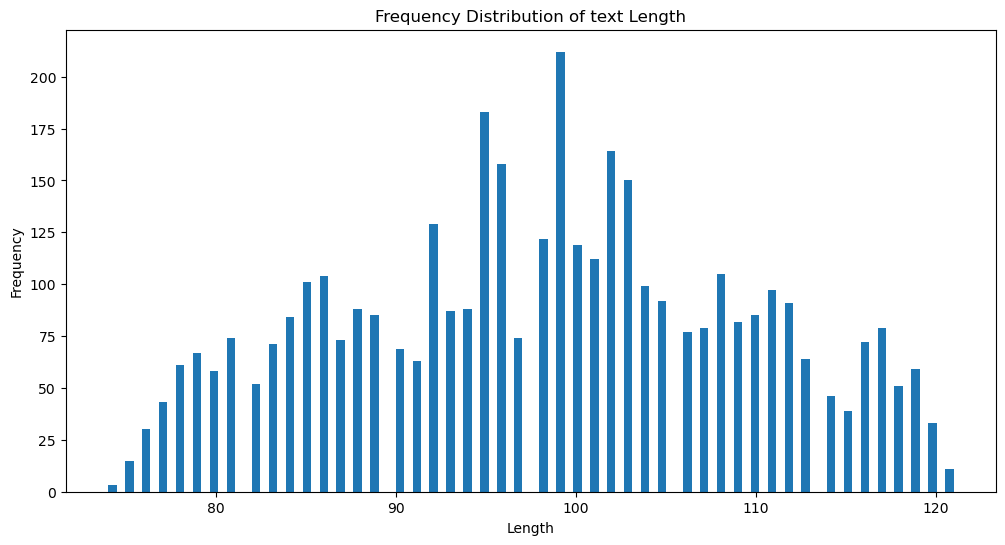

In [22]:
plot_text_length_histogram(ecom)

In [23]:
ecom['length'].describe()

count    4000.000000
mean       98.077000
std        11.228027
min        74.000000
25%        89.000000
50%        99.000000
75%       106.000000
max       121.000000
Name: length, dtype: float64

The histogram peaks around 100 characters, suggesting a unimodal distribution centered near the mean.

The range spans from 74 to 121 characters, indicating a relatively tight clustering of message lengths with no extreme outliers.

Messages don’t differ drastically in length, which implies length alone may not be a strong discriminator for subsequent analyses


## Text Preprocess

In [24]:
ecom['tokens'] = ecom['text'].apply(text_preprocess)

In [25]:
print("Total Text Messages:", len(ecom))
print("Sample tokenized Messages:\n", ecom['tokens'].iloc[0])

Total Text Messages: 4000
Sample tokenized Messages:
 ['aliexpress', 'update', 'package', 'undeliverable', 'fix']


After applying the `text_preprocess` function to all 4,000 messages, we now have a clean `tokens` column. 

This transformation gives us a ready-to-analyze version of the text, where each message is reduced to its most meaningful words. 

Key terms like `"aliexpress"`, `"package"`, and `"undeliverable"` are preserved.

This tokenized format is essential for the next stages of our EDA, such as identifying frequent words, generating n-grams, and exploring semantic relationships.


## WordCloud

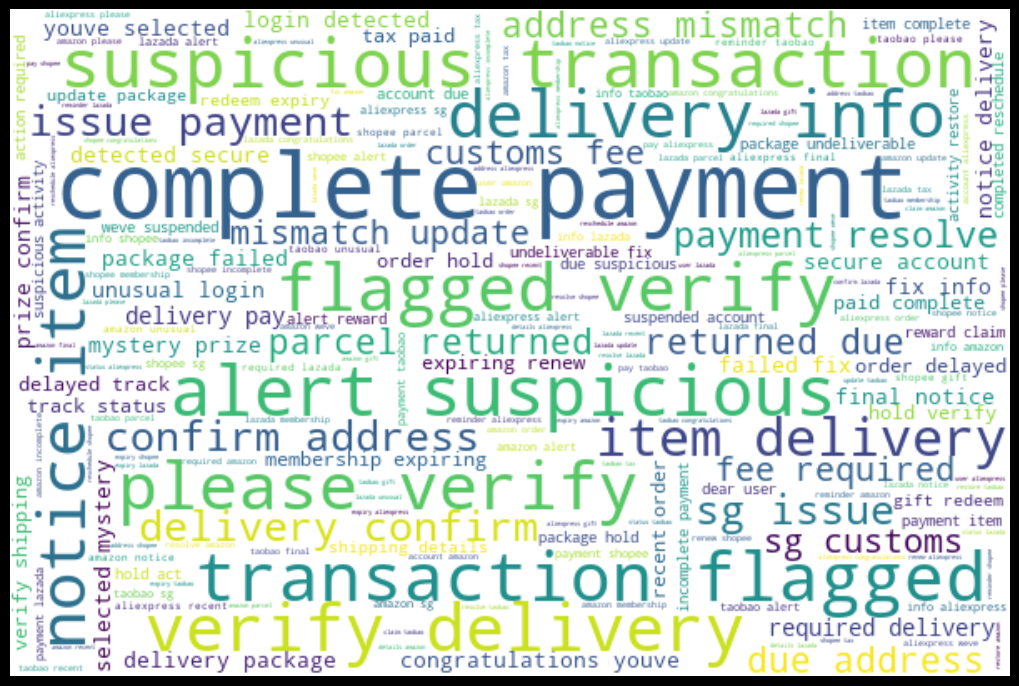

Top 10 frequent words are :

delivery      1024
amazon         845
aliexpress     816
lazada         787
taobao         786
payment        786
shopee         766
verify         626
sg             610
package        565
Name: count, dtype: int64


In [26]:
plot_wordcloud(ecom, tokens_column='tokens')

### Key Observations:

**Dominant Themes**  
The most frequent terms include **"delivery"**, **"payment"**, **"verify"**...

these words point toward common scam tactics—emphasizing urgency.

**Platform Mentions**  
Brand names like **"amazon"**, **"aliexpress"**, **"lazada"**, **"taobao"**, and **"shopee"** appear prominently. This suggests the messages are designed to impersonate familiar singapore platforms to gain user trust and mimic legitimacy.

**Common Scam Triggers**  
Phrases like **"complete payment"**, **"verify address"**, **"please verify"**, and **"suspicious activity"** reinforce the manipulation tactic.

This analysis helps us understand how scammers structure language to appear trustworthy and persuasive. It also guides our future feature engineering—highlighting keywords or n-grams that may be strong indicators of scam content in SMS messages.

The word cloud and frequency analysis offer a clear thematic overview of the dataset, revealing how e-commerce scam messages rely on a blend of urgency, familiarity, and transactional language to deceive people. 


## Semantic Similarity Graphing


- Detect clusters of similar scam tactics.
- Identify outlier messages with distinct language.
- Visually explore common phrasings or repeated scam strategies.


In [27]:
# Subset only top 300 messages to avoid graph overload
ecom_top = ecom.sample(n=300, random_state=42).reset_index(drop=True)


# Embed
ecom_embeddings = embed_sms_with_bert(ecom_top)


Loading model: all-MiniLM-L6-v2
Encoding 300 texts from column: 'text'


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
similarity_matrix = compute_cosine_similarity_matrix(ecom_embeddings)

Calculating cosine similarity matrix...
Matrix shape: (300, 300)


In [29]:
G = build_similarity_graph(similarity_matrix, ecom_top, threshold=0.82)


Building similarity graph (threshold > 0.82)...
Graph created with 300 nodes and 498 edges.


Plotting similarity graph WITH labels...


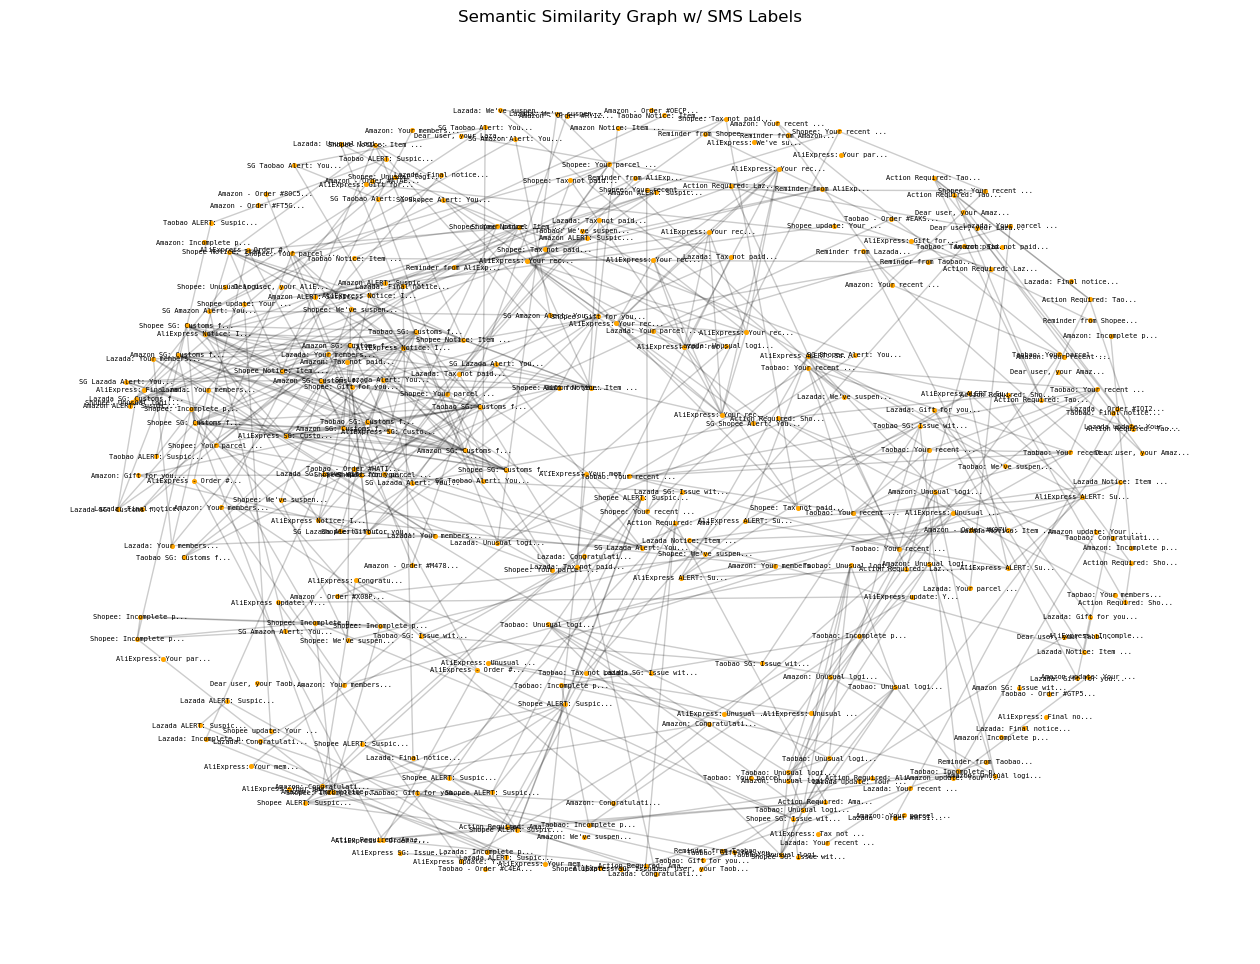

In [30]:
plot_similarity_graph_with_labels(G, ecom_top)

### Key Observations:

**Clear Clustering Behavior**
Distinct clusters of messages can be seen across the graph, indicating that multiple SMS messages share highly similar language patterns or intent.

The clusters show that many scam SMS messages are likely variations of the same few base templates, differing only in product names, order numbers, or minor details.

For example,we see many nodes centered around brands like **"Amazon"**, **"AliExpress"** tend to group closely, suggesting repeated templates or reused scam phrasing.

**Semantic Redundancy**
The dense interconnections between many nodes reveal high **textual redundancy** across scam messages. This confirms that many scammers reuse similar templates with slight variations.

**Structural Density**
With **300 nodes** and **498 edges**, the graph shows a well-connected semantic structure. Certain nodes serve as **hubs**, indicating messages that are semantically similar to many others.

**Isolated Nodes or Sparse Links**
One or Two appear loosely connected or isolated, which could indicate outlier messages, those with unique content or altered structure. These are worth investigating further as they may represent evolving scam tactics 


## Bigrams

In [31]:
get_top_bigrams(ecom)

Top 10 Bigrams:
                bigram  frequency
2691       http lazada        523
2692       http shopee        503
2808         info http        416
2367  complete payment        388
5004      payment http        388
5547         taobao sg        360
5410         shopee sg        335
971        amaz secure        306
2687         http amaz        306
5400   shopee delivery        283


bigram  frequency
2691        http lazada        523
2692        http shopee        503
2808          info http        416
2367   complete payment        388
5004       payment http        388
...                 ...        ...
2098  com resolve15i1h2          1
2097  com resolve12c642          1
2096  com resolve0qafq3          1
2095    com resetzy059d          1
6235    zxm7ug returned          1

[6236 rows x 2 columns]

**Dominance of "http" in Bigrams**
- **Examples**: `"http lazada"`, `"http shopee"`..
The frequent appearance of `"http"` as the first or second word in a bigram strongly suggests that the majority of scam messages include **embedded phishing links**.

Attackers typically use URLs disguised to look like legitimate platforms (e.g., Lazada, Shopee, Amazon) to direct users to fake sites that steal credentials or payment info.

URLs are a core scam mechanism making them a highly predictive feature for any classification model.


**Platform-Specific Impersonation**
- **Examples**:`"taobao sg"`, `"shopee sg"`

These bigrams highlight brand impersonation tactics. The use of well-known sinagpore e-commerce platforms is intended to create trust and reinforce authenticity.

**Call-to-Action Language**
- **Examples**: `"complete payment"`, `"payment http"`, `"shopee delivery"`.

These word pairs are crafted to create urgency to pressuring users to "complete a payment", "verify delivery", or click a link to resolve an issue.

**Long Tail of Rare Bigrams**

Out of **6,236 unique bigrams**, the vast majority (over 6,000) appear only **once**.
This suggests that while many messages follow a **templated structure**, scammers often inject **randomized tokens (e.g., IDs or code fragments)** into URLs to evade detection by spam filters.

  
The bigram analysis reveals that scam messages rely heavily on **URL embedding**, **platform impersonation**, and **urgency-based phrasing**.

The **top bigrams** appear between **283 to 523 times** out of 4,000 messages — this means each of these appears in roughly **7% to 13%** of the dataset.
For a real-world SMS dataset, this is **considered high** frequency. Most natural language datasets have sparse bigram counts, with top phrases rarely exceeding 2–3%.
As our sythetic dataset is **template-driven** which **justifies the higher repetition**.



**Good for Pattern Recognition**
The **high frequency** of top bigrams means the models can easily learn **distinctive patterns** used in ecom scam messages
This can help to improves **model confidence and interpretability**, as these repeated phrases are often the key indicators of fraudulent content.

However, when a few phrases appear too frequently the models may become over-reliant on them. This can lead to **overfitting**—


Overall, bigrams with frequencies over **100 occurrences (~2.5%)** are highly significant and can be treated as **core features**.

Bigrams with **20–100 occurrences (0.5%–2.5%)** are moderately useful and can support **secondary pattern recognition**.

Bigrams that occur **once or a few times** are often too specific or noisy, 

In [32]:
get_top_trigrams(ecom)

Top 10 Trigrams:
                    trigram  frequency
1184  complete payment http        388
2019       http amaz secure        306
2031         http taobao sg        279
2015      http ali shipment        277
2018       http alx payment        273
2020      http amazon prime        272
2021            http amz sg        267
2022      http laz shipping        264
2029            http shp sg        263
2028         http shopee sg        258


trigram  frequency
1184    complete payment http        388
2019         http amaz secure        306
2031           http taobao sg        279
2015        http ali shipment        277
2018         http alx payment        273
...                       ...        ...
2627        m5rdqh failed fix          1
2626        m58243 failed fix          1
2625       m478dy hold verify          1
2624        m41253 failed fix          1
7436  zxm7ug returned address          1

[7437 rows x 2 columns]

To deepen our understanding of message structure, we went on to analyze how often top bigrams appear within the top trigrams. This helps us assess how scam messages are constructed: are they just extending base templates, or introducing new, unique linguistic patterns?


Out of the top 10 trigrams, **7** directly **contain bigrams** from the top 10 bigram list
( Partial, implied, variant) 
That’s a **70% overlap**, showing that many trigrams are simply **extended versions** of already frequent bigrams.

**Layered Template Design**

Scammers are **stacking phrases** in a structured way: base bigram + extra keyword.

This implies a **modular template construction**, which is common in mass SMS scam campaigns.

This indicates that bigrams are **foundational building blocks** of scam messages

**Predictable Linguistic Progression**

The reuse of bigrams in trigrams confirms that message templates **evolve linearly**, often by just adding a link or a target action.

These predictable patterns are highly learnable by NLP models and even interpretable by humans.

 
A significant portion (70%) of the most frequent trigrams are directly built on top of the most frequent bigrams. This confirms that the dataset follows a **template-driven, modular structure**, which makes it highly suitable for feature based modeling, explainable AI, and anomaly detection.


## TF-IDF

Top 10 words by TF-IDF score:
            word       score
2023        http  284.229634
4078          sg  262.708519
2116      lazada  245.369638
4082      shopee  238.703254
447       amazon  202.638104
443   aliexpress  199.265723
1137    delivery  199.121904
4116      taobao  196.410368
438        alert  192.925095
2732     payment  190.271624


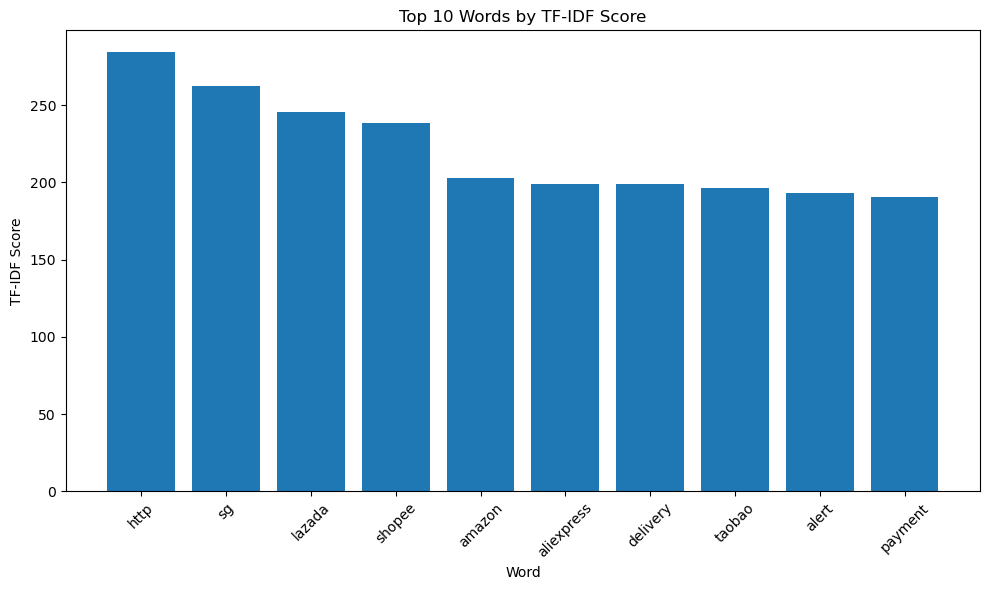

word       score
2023       http  284.229634
4078         sg  262.708519
2116     lazada  245.369638
4082     shopee  238.703254
447      amazon  202.638104
...         ...         ...
1371  fixfdvy01    0.504725
2152     mqmw0s    0.504725
124      601bwo    0.504725
3055     r34qlo    0.504725
1485  fixosq30n    0.504725

[5098 rows x 2 columns]

In [33]:
get_top_tfidf_words(ecom)

TF-IDF (Term Frequency–Inverse Document Frequency) highlights terms that are not only frequent but also informative. we are looking fro words that appear often in some messages but are not too common across all messages. This makes it particularly useful for identifying key differentiators in scam language, beyond simple repetition.

 **Overlap With Word Cloud & N-grams**
 
Many of the top TF-IDF words — **"http"**, **"lazada"**, **"shopee"**, are also dominant in the **word cloud**, bigrams, and trigrams.

This overlap confirms these words are **both frequent and highly distinctive** across the dataset.

They provide strong signals for modelling

TF-IDF focuses on what terms are uniquely informative, while bigrams/trigrams reveal how those terms are phrased in context. Together, they provide a more complete linguistic picture.

Some words like `"alert"` rank high in TF-IDF but don’t appear in the top bigrams/trigrams

Hence we can surface words that are underrepresented in phrase-level analysis but still hold semantic importance.
These words are often **discriminative** and help in classification, even though they don't show up in the most common structural templates.


## LDA Topics

In [34]:
display_lda_topics(ecom, num_topics=5, num_words=5, passes=10, random_state=42)

Topic: 0 
Words: 0.071*"due" + 0.070*"suspicious" + 0.037*"address" + 0.037*"returned" + 0.037*"mismatch"
Topic: 1 
Words: 0.104*"package" + 0.104*"fix" + 0.053*"notice" + 0.053*"delivery" + 0.053*"info"
Topic: 2 
Words: 0.054*"account" + 0.054*"unusual" + 0.054*"secure" + 0.054*"detected" + 0.054*"login"
Topic: 3 
Words: 0.115*"delivery" + 0.079*"verify" + 0.075*"required" + 0.040*"reminder" + 0.040*"please"
Topic: 4 
Words: 0.144*"payment" + 0.075*"sg" + 0.073*"item" + 0.071*"complete" + 0.041*"amazon"




LDA is an unsupervised technique used to discover latent topics in a corpus by analyzing patterns of word co-occurrence. Each topic is represented by a list of top keywords, which can be interpreted to reveal the underlying themes present in the text.

**Topic 0 – Address Mismatch / Return Alerts**

This topic likely captures failed delivery or address-related issues, often used to create urgency or suspicion 

---
 **Topic 1 – Delivery Fix Notifications**
 
This topic centers around package delivery problems, typically suggesting the user needs to "fix" or "verify" a delivery. These messages may include tracking links or request updated info.

---
 **Topic 2 – Account Security Warnings**

A classic phishing tactic — this topic reflects messages warning users of unauthorized logins or suspicious activity, prompting them to "secure" their account.

---

 **Topic 3 – Delivery Verification Requests**
 
This theme covers polite reminders or soft-scam prompts urging users to verify delivery or payment status. The tone is often less threatening, but still pressure-inducing.

---

 **Topic 4 – Payment & Checkout**
 
This topic likely captures messages related to checkout, payment confirmation, or fake transaction alerts, especially impersonating local platforms (`"sg"`, `"amazon"`).

---

- Each topic is interpretable, with minimal word overlap.

- Topics 1 and 3 both relate to **delivery**, suggesting slight thematic overlap. 
- Topics like `"payment"` and `"verify"` show up in multiple topics, hinting at **cross-topic vocabulary** — common in short message corpora.
- Increased `num_topics` to **6–8**, will isolate more specific variations, we can get finer distinctions.(e.g., splitting Amazon vs. Shopee scams).




# Financial scam dataset

In [35]:
fin = fin.drop(columns='Label') 
fin.columns = ['text']
print(fin.columns)


Index(['text'], dtype='object')


In [36]:
print(fin.head())
print(fin.info())
print(fin.describe())

                                                text
0  POSB Security Notice: update security settings...
1  URGENT: eStatement access issue has triggered ...
2  URGENT: fraud alert has triggered a security h...
3  [DBS] ALERT: Your account faces unauthorised t...
4  OCBC Fraud Prevention: Action needed due to ch...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
dtypes: object(1)
memory usage: 31.4+ KB
None
                                                     text
count                                                4000
unique                                               4000
top     POSB Security Notice: update security settings...
freq                                                    1


In [37]:
fin['length'] = fin['text'].apply(len)
fin.head()

text  length
0  POSB Security Notice: update security settings...     127
1  URGENT: eStatement access issue has triggered ...     119
2  URGENT: fraud alert has triggered a security h...     112
3  [DBS] ALERT: Your account faces unauthorised t...     122
4  OCBC Fraud Prevention: Action needed due to ch...     130

## Text length Distribution

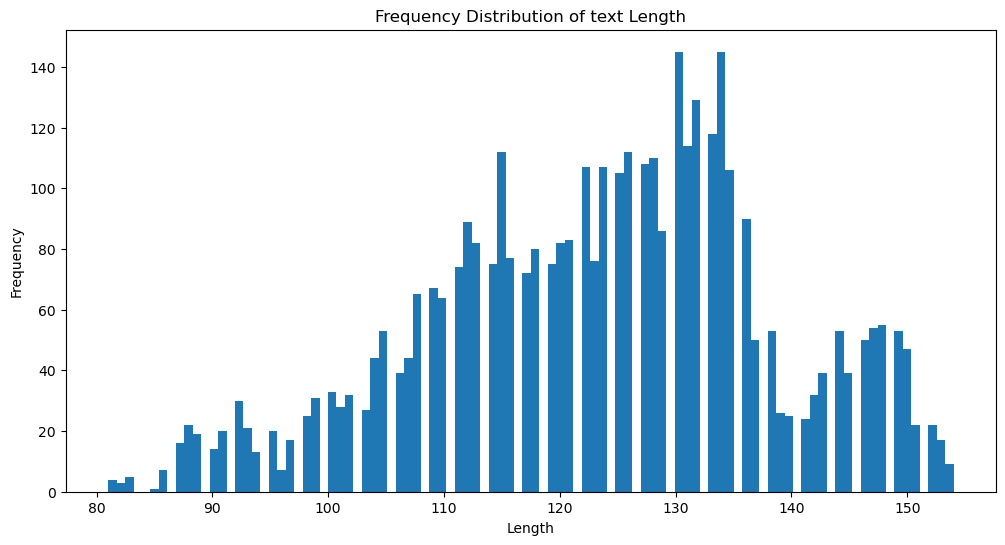

In [38]:
plot_text_length_histogram(fin)

In [39]:
fin['length'].describe()

count    4000.000000
mean      123.444500
std        14.935936
min        81.000000
25%       113.000000
50%       125.000000
75%       134.000000
max       154.000000
Name: length, dtype: float64

The distribution of text lengths in the financial scam SMS dataset shows a strong **right-skewed bell shape** centered around **125 characters**, with most messages ranging from **113 to 134 characters** (IQR). 

- **Median (50%)**: 125 — indicating a fairly symmetric central tendency
- **Standard Deviation**: 14.94 — relatively low, showing consistency in message length
---

 **No Extreme Outliers**: 
 
 There are no ultra-short or overly long messages
 
**Longer Than E-commerce Messages**:

Compared to the e-commerce dataset (which centered around ~98 characters), financial scam messages are longer on average. 

The consistent text lengths across messages support the notion that financial scams rely on professional-sounding, structured formats.

## Text Perprocess

In [40]:
fin['tokens'] = fin['text'].apply(text_preprocess)

In [41]:
print("Total Text Messages:", len(fin))
print("Sample tokenized Messages:\n", fin['tokens'].iloc[0])

Total Text Messages: 4000
Sample tokenized Messages:
 ['posb', 'security', 'notice', 'update', 'security', 'settings', 'account', 'click', 'review', 'ref']


## WordCloud

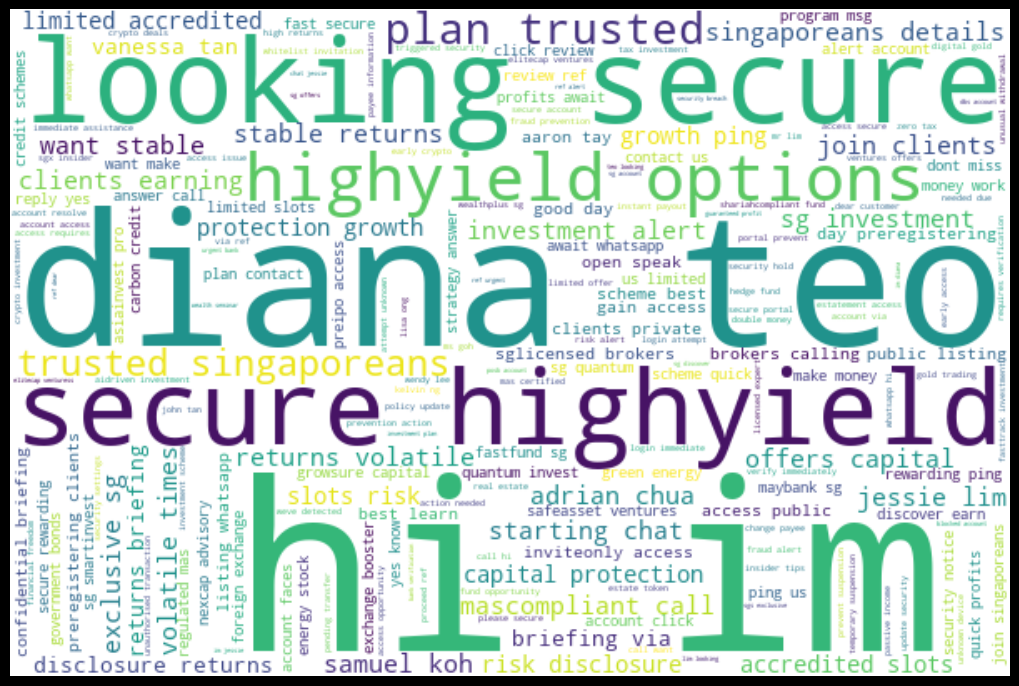

Top 10 frequent words are :

access        963
sg            950
account       689
secure        684
investment    664
hi            565
returns       564
alert         564
briefing      484
clients       477
Name: count, dtype: int64


In [42]:
plot_wordcloud(fin, tokens_column='tokens')

The word cloud and top frequency counts give us a clear picture of the language tactics used in financial scam SMS campaigns. This set relies more on financial buzzwords, credibility hooks, and personalized contact names.

---

 **Financial and Technical Jargon**
 
Words like **"investment"**, **"returns"**, and **"clients"** aim to establish professionalism.
These are classic finance-oriented hooks meant to mimic real advisors, brokers, or portfolio managers.

 **Access Language**
Terms like **"access"**, **"alert"**, and **"secure"** are engineered to create a sense of urgency, exclusivity.

**Personalization & Humanization**
Prominent names like “Diana Teo” and “Adrian Chua” suggest an effort to humanize the scam by impersonating financial agents.
This increases trust and lowers suspicion — a tactic distinct from e-commerce scams which rarely use full names.


## Semantic Similarity Grouping

In [43]:
# Subset only top 300 messages to avoid graph overload
fin_top = fin.sample(n=300, random_state=42).reset_index(drop=True)

# Embed
fin_embeddings = embed_sms_with_bert(fin_top)

Loading model: all-MiniLM-L6-v2
Encoding 300 texts from column: 'text'


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
G = build_similarity_graph(similarity_matrix, fin_top, threshold=0.82)

Building similarity graph (threshold > 0.82)...
Graph created with 300 nodes and 498 edges.


Plotting similarity graph WITH labels...


C:\Users\GAdmin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


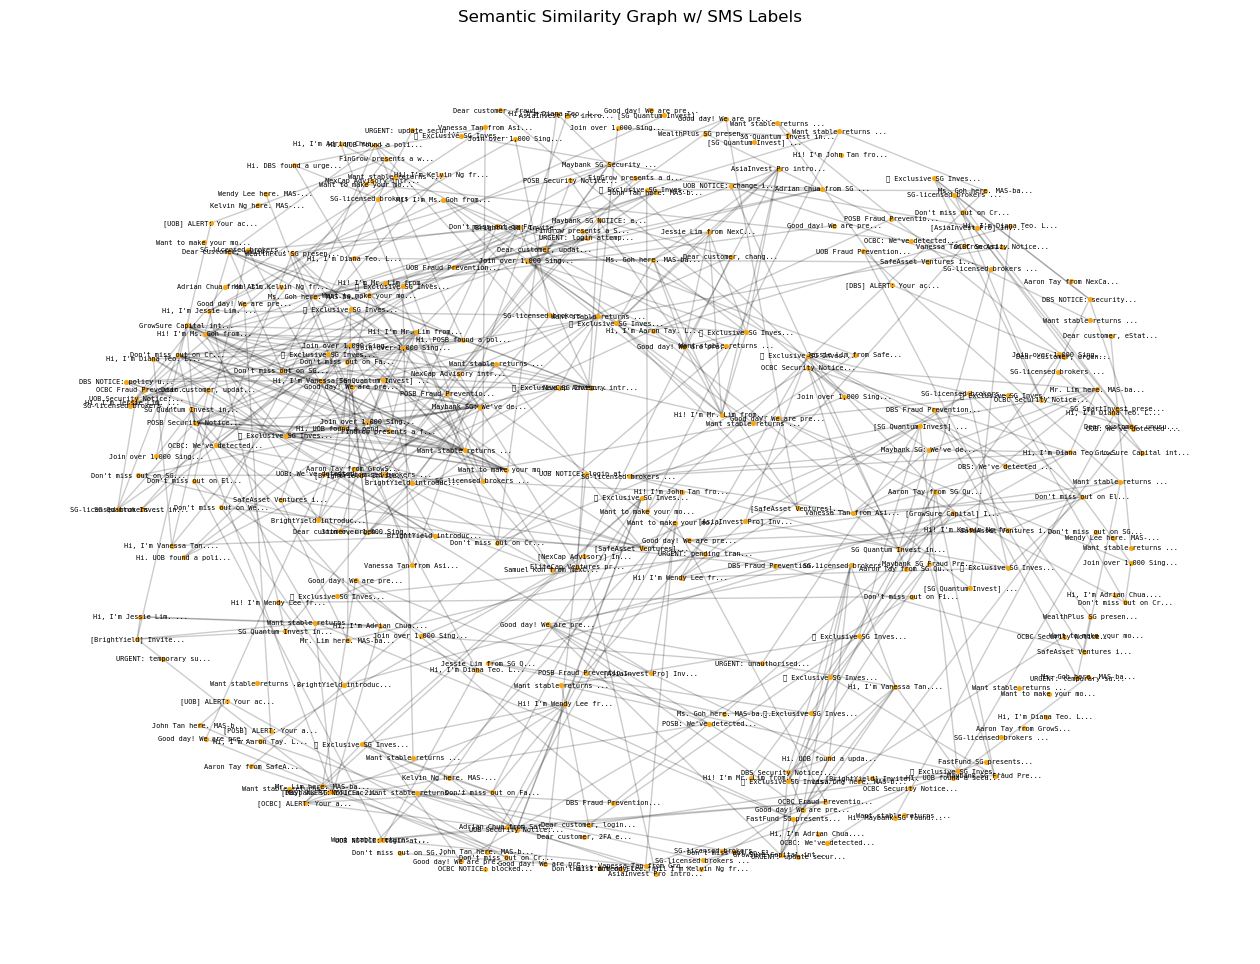

In [45]:
plot_similarity_graph_with_labels(G, fin_top)

 **Densely Interconnected Clusters**
 
Multiple **well-connected clusters** form around phrases like “Hi, I’m [name]”, “exclusive offer”, “secure returns”, and “account alert”.

This indicates **repetitive template usage**, with only slight variations in wording, a strong sign of **scripted scam behavior**.

---
 **Persona-Based Clustering**
 
One cluster heavily features introductions like **“Hi, I’m Jessie Lim”**, **“Vanessa Tan from...”**, or **“Adrian Chua ”**  indicating a subgroup of messages built around **agent impersonation** 

---

 **Alert & Security**
 
A separate cluster contains messages related to **“DBS Notice”**, **“OCBC Security”**, or **“Fraud Prevention”**  targeting user fear by mimicking banks and financial alerts.

---

 **Sparse Nodes / Weak Links**
 
A few nodes are sparsely connected or almost isolated.

**Outlier templates** (rare scam formats)
**Newer or less common variations** that don’t yet follow dominant patterns

---

 
The financial scam messages exhibit **high semantic redundancy**, with clear clusters around agent impersonation, secure investments, and fraud alerts. These patterns reinforce the idea that scams are built from **modular, repeated structures**, making them highly detectable.


## Bigram

In [46]:
get_top_bigrams(fin)

Top 10 Bigrams:
                    bigram  frequency
0         000 singaporeans        429
4990           whatsapp 65        414
3601             diana teo        279
4904           trusted 000        278
3767            high yield        278
4144          plan trusted        278
3572            details 65        278
4737  singaporeans details        278
4652           secure high        278
3909        looking secure        278


bigram  frequency
0     000 singaporeans        429
4990       whatsapp 65        414
3601         diana teo        279
4904       trusted 000        278
3767        high yield        278
...                ...        ...
1758       65 95126185          1
1757       65 95122934          1
1756       65 95112653          1
1755       65 95111323          1
2504       65 98460300          1

[5009 rows x 2 columns]

 **Identity-Based Targeting**
 
“000 singaporeans” and “trusted 000” suggest identity spoofing 

---

 **Direct Contact Scams**
 
“whatsapp 65” and “details 65” point to Singapore-based mobile numbers, reinforcing that users are prompted to engage directly — often a red flag for scam behavior.
The inclusion of phone numbers is a clear attempt to bypass platform moderation and move users into unmonitored channels.

---

 **Buzzwords for High ROI**
 
Phrases like “high yield”, “plan trusted”, and “secure high” mimic language from real investment ads.
This reflects a content strategy designed to hook financially curious users with the promise of stability or exclusivity.

---

**Heavy Reuse of Structured Phrases**

Many of the top bigrams have identical frequency values (278) — as they’re pulled from synthetic generation rather than organically generated text.

---

With top bigrams appearing **278–429 times in a 4,000 message dataset**, they account for **7%–10%** of all messages — a **very high repetition rate**.




In [47]:
get_top_trigrams(fin)

Top 10 Trigrams:
                       trigram  frequency
5886  trusted 000 singaporeans        278
3980       looking secure high        278
1     000 singaporeans details        278
4612          plan trusted 000        278
3374        high yield options        278
5279   singaporeans details 65        278
5031         secure high yield        278
3083   exclusive sg investment        275
5352         starting 100 chat        275
5148       sg investment alert        275


trigram  frequency
5886        trusted 000 singaporeans        278
3980             looking secure high        278
1           000 singaporeans details        278
4612                plan trusted 000        278
3374              high yield options        278
...                              ...        ...
750   97033297 confidential briefing          1
751   97101107 confidential briefing          1
752   97111538 confidential briefing          1
753   97180709 confidential briefing          1
3327                   hi ocbc login          1

[6654 rows x 2 columns]



The top trigrams in the financial scam dataset reveal even tighter structure and formulaic messaging than bigrams, 

---
 **Repetition = Template Usage**
 
All top trigrams occur **278–275 times** — identical to the top bigrams. 
This strongly indicates that scammers are using **copy-pasted message templates** with only minor variations (e.g., names, numbers).

---

**Trust & Locality Themes Continue**

Phrases like `"trusted 000 singaporeans"`, `"plan trusted 000"`, and `"sg investment alert"` reinforce themes of **local targeting** (via "Singaporeans", "sg") and **legitimacy claims** (via "trusted", "investment").
Scam messages attempt to simulate official schemes or exclusive offers meant for Singapore region.

---

 **Conversion-Focused Calls-to-Action**
 
`"starting 100 chat"` hints at a clear monetary ask, followed by a WhatsApp prompt.

---
  
**80% of top trigrams** 
are direct extensions of the most common bigrams.
This demonstrates that scammers **layer messaging** using a base structure (bigram), then append financial or contextual terms to produce variants.

---

The financial scam messages show extremely rigid trigram structures built from bigram foundations. With 80%+ overlap between top bigrams and trigrams, it’s clear that scammers use templated language blocks designed for scale and impact. 


## TF-IDF

Top 10 words by TF-IDF score:
            word       score
4             65  239.156991
3559          sg  195.310324
2939       https  154.066382
2849      access  151.235267
3554      secure  137.084358
2850     account  123.874438
2970         mas  119.812590
2948  investment  118.899304
2936          hi  110.484464
2856       alert  107.999480


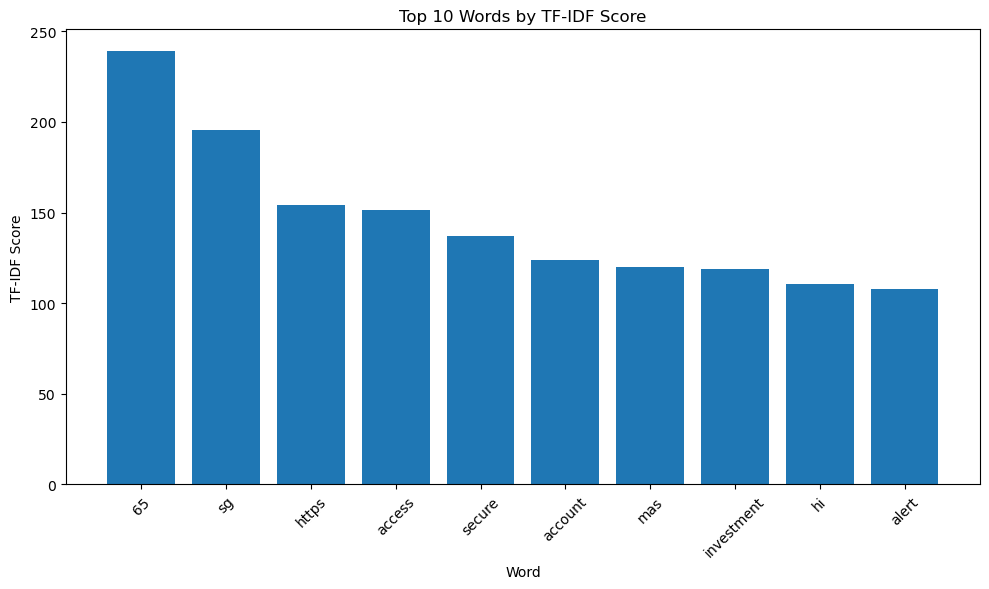

word       score
4              65  239.156991
3559           sg  195.310324
2939        https  154.066382
2849       access  151.235267
3554       secure  137.084358
...           ...         ...
3113  ref299174sg    0.462743
3107  ref290843sg    0.461155
3246  ref534480sg    0.460774
3398  ref788048sg    0.459071
3528  ref977171sg    0.453886

[3609 rows x 2 columns]

In [48]:
get_top_tfidf_words(fin)

 **Contact & Redirection Phrases**
“65”, “sg”, and “https” dominate due to repeated inclusion of Singapore-based contact number and clickable URLs, typically pointing to WhatsApp, pre-filled forms, or fake financial advisors.

---
 **Exclusive Financial Access**
“access”, “investment”, and “secure” align with high-pressure tactics promising limited-time offers, private briefings, or fast-track financial gains.
- 
These words focus on enticing the recipient rather than threatening consequences 

 **Regulatory Mimicry**
The presence of “mas” (Monetary Authority of Singapore) suggests that scammers reference real institutions to fake legitimacy or appear government-backed

 **Conversational Starters**
“hi” scoring high supports earlier observations that messages often begin with a casual, personalized tone to lower suspicion and build rapport.

---



## LDA TOPIC

In [49]:
display_lda_topics(fin, num_topics=5, num_words=5, passes=10, random_state=42)

Topic: 0 
Words: 0.056*"limited" + 0.050*"slots" + 0.039*"returns" + 0.039*"risk" + 0.035*"briefing"
Topic: 1 
Words: 0.040*"access" + 0.035*"clients" + 0.021*"plan" + 0.020*"looking" + 0.020*"options"
Topic: 2 
Words: 0.090*"secure" + 0.067*"hi" + 0.067*"im" + 0.056*"singaporeans" + 0.025*"yes"
Topic: 3 
Words: 0.050*"sg" + 0.049*"capital" + 0.042*"investment" + 0.042*"ping" + 0.042*"offers"
Topic: 4 
Words: 0.076*"account" + 0.043*"ref" + 0.043*"security" + 0.032*"alert" + 0.030*"access"


 **Topic 0 – High-Yield Briefings & Risk**
 
This topic centers around exclusive investment events or promotions, often advertised with phrases like “limited slots” or “high returns.” The inclusion of `"risk"` and `"briefing"` suggests attempts to simulate professional advisory settings, possibly mimicking wealth management firms.

---

**Topic 1 – Client Access & Investment Planning**

This group reflects a more polished advisory tone. The use of `"clients"`, `"plan"`, and `"options"` mimics language from legitimate financial advisors. These messages aim to appear as tailored wealth-building plans, especially when paired with phrases like “access for premium clients.”

---

 **Topic 2 – Personalized Scam Openers**
 
This topic is clearly tied to casual, conversational openers. It blends personal introductions with keywords like `"secure"` and `"yes"` — reflecting how scammers humanize the message to gain trust while subtly pitching exclusivity to Singaporean audiences.

---

**Topic 3 – SG Investment Offers**
  
Messages in this topic emphasize investment opportunities branded for Singaporeans. Words like `"capital"` and `"offers"` align with typical promotional language, while `"ping"` suggests informal call-to-actions, commonly seen in scam messages directing users to reply or WhatsApp.

---

 **Topic 4 – Fake Account Alerts & Security Ref Codes**
 
This is the only topic that crosses slightly into phishing-style content, but within a financial scam frame. The presence of `"ref"` and `"alert"` suggests fake system-generated notices (e.g., “Your account security alert: REF #12345”). These are crafted to simulate urgency and gain credibility — especially in high-trust domains like finance.

---

All five topics are **distinct and interpretable**, each aligned with a **different scam strategy** 

No topics appear to be incoherent or heavily overlapping — ideal for both analysis and downstream clustering.


Topics 0 and 1 both touch on **investment promotion**, but differ in tone (formal briefing vs. client-tailored). Merging them into one might be possible if reducing topic count.

Topics 2 and 3 could become more distinct if expanded into 6–7 topics, especially to better separate **introductory messages** from **offers**.



## Crypto Dataset

In [50]:
crypto = crypto.drop(columns='label') 
crypto.columns = ['text']
print(crypto.columns)


Index(['text'], dtype='object')


In [51]:
print(crypto.head())
print(crypto.info())
print(crypto.describe())

                                                text
0  Invest $7976 now and get 10x returns in 24 hours!
1  Participate in our giveaway and win up to 0.26...
2  Participate in our giveaway and win up to 3.92...
3  Congratulations! You've won 0.7 BTC. Claim it ...
4  Limited offer: Buy crypto and get a bonus of 4...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
dtypes: object(1)
memory usage: 31.4+ KB
None
                                                     text
count                                                4000
unique                                               4000
top     Invest $7976 now and get 10x returns in 24 hours!
freq                                                    1


In [52]:
crypto['length'] = crypto['text'].apply(len)
crypto.head()

text  length
0  Invest $7976 now and get 10x returns in 24 hours!      49
1  Participate in our giveaway and win up to 0.26...      61
2  Participate in our giveaway and win up to 3.92...      61
3  Congratulations! You've won 0.7 BTC. Claim it ...      71
4  Limited offer: Buy crypto and get a bonus of 4...      66

# Text Length Distribution

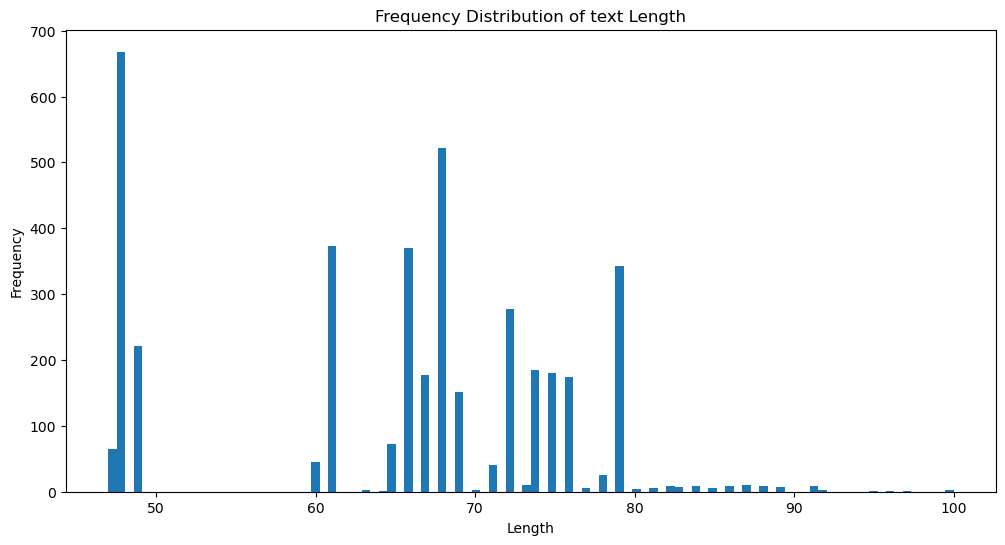

In [53]:
plot_text_length_histogram(crypto)

In [54]:
crypto['length'].describe()

count    4000.000000
mean       64.972250
std        10.850065
min        47.000000
25%        61.000000
50%        68.000000
75%        74.000000
max       100.000000
Name: length, dtype: float64

The crypto scam messages show a **highly fragmented and irregular** text length distribution, significantly different from the e-commerce and financial datasets analyzed earlier.

The most common message lengths are clustered between **47–50 characters**, with an unusually **sharp peak** at the lower bound. As this can suggests that some crypto scam messages are being **minimalistic**. 
 
Crypto scams are **shorter texts** compared to financial scams and also e-commerce scams

# Text Preprocess

In [55]:
crypto['tokens'] = crypto['text'].apply(text_preprocess)

In [56]:
print("Total Text Messages:", len(crypto))
print("Sample tokenized Messages:\n", crypto['tokens'].iloc[0])

Total Text Messages: 4000
Sample tokenized Messages:
 ['invest', 'get', 'returns', 'hours']


# WordCloud

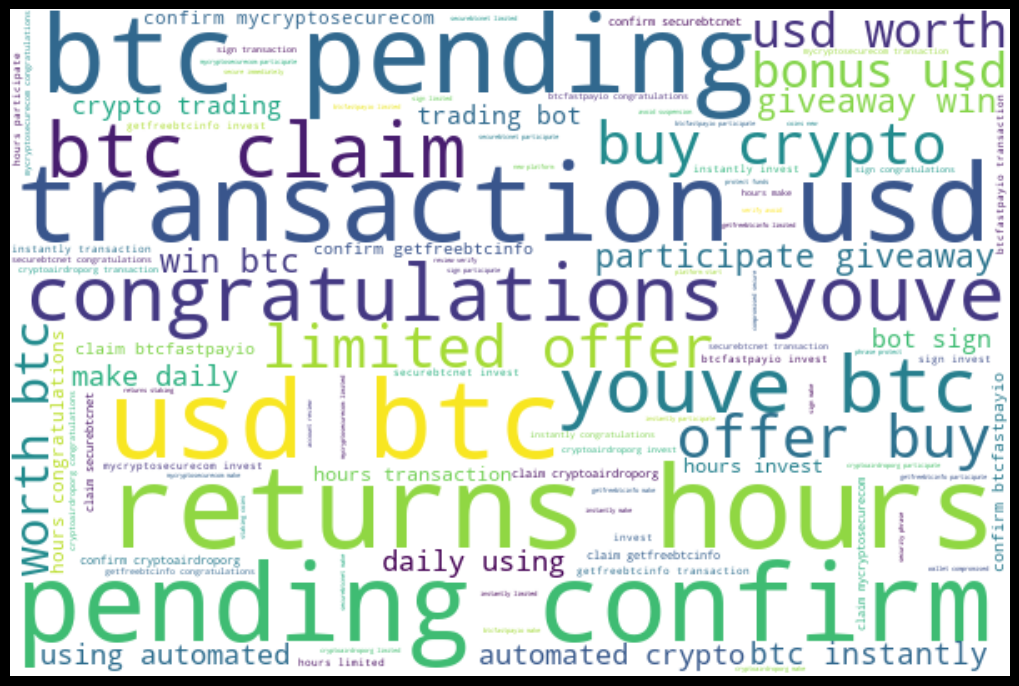

Top 10 frequent words are :

btc            2555
get            1394
usd            1316
returns         974
invest          954
hours           954
transaction     901
confirm         896
pending         896
claim           821
Name: count, dtype: int64


In [57]:
plot_wordcloud(crypto, tokens_column='tokens')

The word cloud and frequency distribution of the crypto scam dataset reveal a **clear thematic focus on cryptocurrency giveaways, transaction confirmations, and financial returns**, all tightly associated with common crypto fraud tactics.

---

Terms like **"btc"** (Bitcoin) and **"usd"** dominate the vocabulary. But the extremely high counts for key terms (e.g., 2,555 mentions of `"btc"`) reflect **very limited template variety** the same phrases are likely reused heavily across thousands of scam messages.

---

Words like **"returns"**, **"invest"**, **"claim"**, and **"offer"** suggest the core scam structure revolves around **investment promises** or **free cryptocurrency giveaways**.

---

Words such as **"hours"**, **"pending"**, and **"confirm"** create a sense of **time-sensitive urgency**.


The word cloud clearly shows that crypto scam messages are **shorter**, **more aggressive**, and **laser-focused** on promises of instant wealth and urgent transaction claims. The heavy reuse of high-frequency financial buzzwords like `"btc"`, `"usd"`, `"returns"`, and `"confirm"` creates a highly detectable pattern for both manual analysis and automated detection models.

# Semantic Similarity Grouping

In [58]:
# Subset only top 300 messages to avoid graph overload
crypto_top = crypto.sample(n=300, random_state=42).reset_index(drop=True)


# Embed
crypto_embeddings = embed_sms_with_bert(crypto_top)

Loading model: all-MiniLM-L6-v2
Encoding 300 texts from column: 'text'


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [59]:
G = build_similarity_graph(similarity_matrix, crypto_top, threshold=0.82)

Building similarity graph (threshold > 0.82)...
Graph created with 300 nodes and 498 edges.


Plotting similarity graph WITH labels...


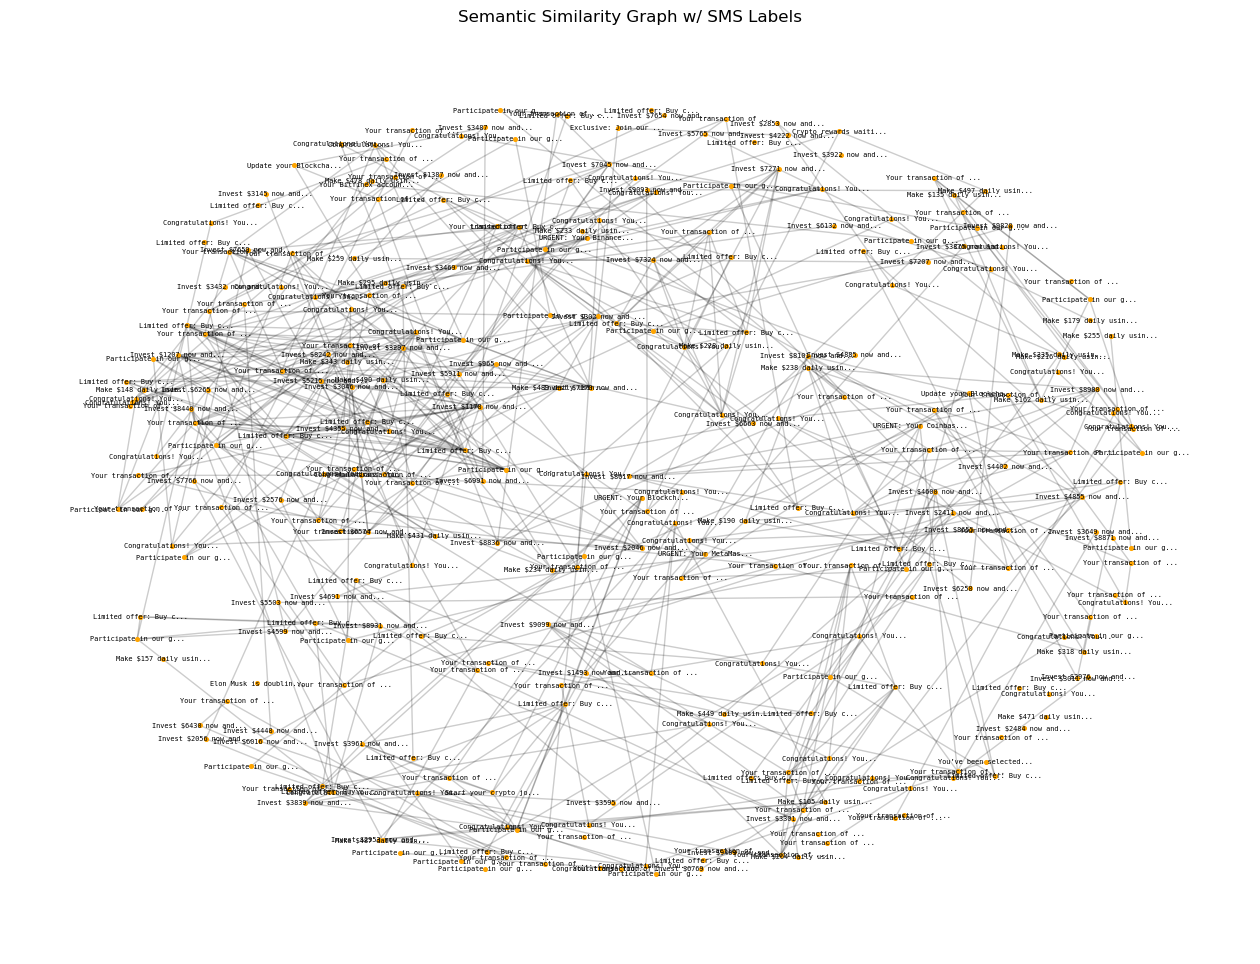

In [60]:
plot_similarity_graph_with_labels(G, crypto_top)

- Several **dense clusters** emerge, each centered around extremely repetitive templates such as:
  - “Congratulations! Your transaction of smth is pending...”
  - “Limited offer! Invest now...”
  - “Your BTC is ready to claim.”
  
The goal is to explore message structure, reuse patterns

  ---
  
With having 300 nodes and hundreds of edges still, the graph shows **heavy message redundancy**.
This redundancy is stronger as comapred to other datasets as crypto scams seem even more **repetitive and copy-pasted**, with minor token changes like varying prices.

---

Easy to identify boilerplate scam formats for filtering or blacklisting.

---

Sparse outliers are **important to monitor** as scammers may be **testing new strategies** as there are new rising scams  referencing NFTs, DeFi apps.

---

Due to the extreme structural repetition, even simple models (TF-IDF + Logistic Regression) could perform well


# Bigrams

In [61]:
get_top_bigrams(crypto)

Top 10 Bigrams:
                  bigram  frequency
542             24 hours        954
4507          returns 24        954
3123         btc pending        896
4497     pending confirm        896
5410             usd btc        896
3142  congratulations ve        811
3119           btc claim        811
5414              ve won        811
5411           usd worth        420
5601           worth btc        420


bigram  frequency
542          24 hours        954
4507       returns 24        954
3123      btc pending        896
4497  pending confirm        896
5410          usd btc        896
...               ...        ...
1919          6602 2x          1
1918           66 usd          1
1916          6598 5x          1
1915          6595 2x          1
5606   x2 1securebtc7          1

[5607 rows x 2 columns]

 **Time-Sensitive Urgency**

the top two pharses **"24 hours"** and **"returns 24"** appear at the highest frequencies (954 times each).
These phrases create immediate pressure as this tatcic is designed to reduce recipient decision time and trigger impulsive responses.

---

**Fake Transaction Status**

**"btc pending"** , **"usd btc"**, **"pending confirm"** occur 896 times each.
These bigrams simulate incomplete crypto transactions 

---

 **Reward Notification Templates**

**"congratulations ve"**, **"btc claim"**, and **"ve won"** occur 811 times each.
These bigrams are tied to fake reward systems like giveaway messages falsely claiming the recipient has won cryptocurrency.
The phrase **"ve"** is a tokenization artifact from "you've", confirming that template structures were highly repetitive and formulaic.

---

 **Heavy Reuse of Structured Phrases**

Many of the top bigrams appear **more than 800 times** across 4,000 messages.
Specifically, `"24 hours"`, `"returns 24"`, `"btc pending"`, `"pending confirm"`, and `"usd btc"` account individually for **over 20% of the dataset** when summed!

This extremely high repetition indicates is the result of **synthetic generation**, rather than organically varied messaging.

This confirms that **a very small number of base templates dominate the dataset** approximately **5 to 7 primary sentence structures** are used repeatedly.




# Trigrams

In [62]:
get_top_trigrams(crypto)

Top 10 Trigrams:
                       trigram  frequency
5204          returns 24 hours        954
6120           usd btc pending        896
3243       btc pending confirm        896
3265    congratulations ve won        811
6121             usd worth btc        420
3244          buy crypto bonus        420
4798         limited offer buy        420
5169          offer buy crypto        420
5170  participate giveaway win        418
5235          trading bot sign        364


trigram  frequency
5204        returns 24 hours        954
6120         usd btc pending        896
3243     btc pending confirm        896
3265  congratulations ve won        811
6121           usd worth btc        420
...                      ...        ...
2350         8197 2x returns          1
2349            8193 usd btc          1
2348         8187 5x returns          1
2347         8185 2x returns          1
3200            bonus 61 usd          1

[6401 rows x 2 columns]

Over **80%** of the top trigrams are **direct logical extensions** of the most frequent bigrams.
No significantly new concepts or strategies are introduced — only **completion of partial ideas** (from urgency/transaction words to full sentences).

Unlike some domains (like financial scams where trigrams introduced new types like "secure high yield" packages), **crypto trigrams do not add new scam types** — they **only complete existing patterns**.

---

Crypto scams show **greater message compression** than financial or e-commerce scams.  
The goal is not persuasive buildup, but **instant call-to-action with minimal reading** required.

---

 **New Tactical Themes Visible in Trigrams**
 
Some trigrams, such as `"buy crypto bonus"` and `"offer buy crypto"`, reveal **investment sales tactics** not as obvious at the bigram level.
 
While trigrams introduce slight new messaging tones (sales language), **they are shallow extensions**, not fundamentally new scam structures. The scam themes remain tightly constrained.



# TF-IDF

Top 10 words by TF-IDF score:
                 word       score
2165              btc  408.173926
2256              usd  249.277954
2176           crypto  225.306259
405                24  223.907503
2168            claim  222.252954
2234          returns  222.235139
2258               ve  222.167192
2264              won  221.772088
2175  congratulations  221.772088
2202           invest  220.982954


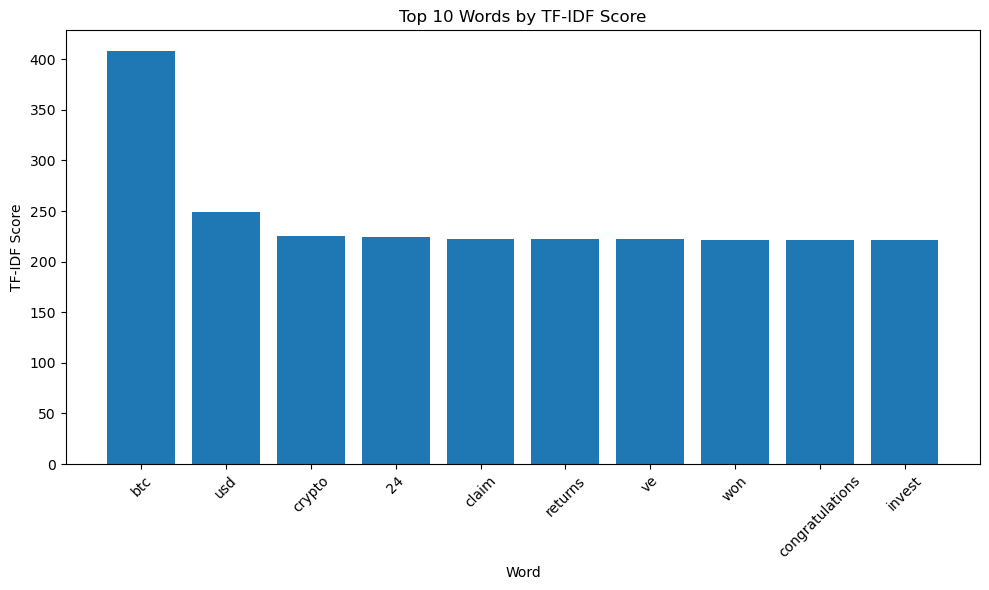

word       score
2165            btc  408.173926
2256            usd  249.277954
2176         crypto  225.306259
405              24  223.907503
2168          claim  222.252954
...             ...         ...
286   1claimnowbtc2    0.373852
287   1elonpromobtc    0.373852
288   1giveawaybtc9    0.373852
289     1muskbtc123    0.373852
290     1securebtc7    0.373852

[2267 rows x 2 columns]

In [63]:
get_top_tfidf_words(crypto)

 The top TF-IDF words (`btc`, `usd`, `crypto`, `24`, `claim`) concentrate overwhelmingly around **cryptocurrency assets**, **returns**, and **immediate action**.
**No external topics**, alternative scam styles, or broader conversational language are introduced.
This shows **tight message framing** — the scams stay almost exclusively within the "crypto + reward + urgency" semantic field.

Crypto scam messages exhibit **much narrower topical diversity** than financial or e-commerce scams, heavily fixated on **digital assets and instant gains**. like they are hyper-focused on cryptocurrency terminology

---

The number **"24"** appears prominently (TF-IDF score ~224), reflecting the repeated time-based urgency ("24 hours") seen earlier.


---

**Minimal Informational Depth**

Compared to the financial dataset ,  the crypto TF-IDF terms are purely surface-level:

Crypto scam messages maintain extremely shallow informational structures LIKE  no advisory pretext, no regulatory references — just asset names and reward prompts.

---
 
TF-IDF reveals that the crypto SMS scam dataset operates with an extremely constrained.
This tight language control makes the dataset highly learnable, but also highly vulnerable to detection models that exploit semantic redundancy.



# LDA Topic

In [64]:
display_lda_topics(crypto, num_topics=5, num_words=5, passes=10, random_state=42)

Topic: 0 
Words: 0.140*"btc" + 0.139*"transaction" + 0.138*"usd" + 0.137*"confirm" + 0.137*"pending"
Topic: 1 
Words: 0.181*"get" + 0.126*"returns" + 0.124*"hours" + 0.124*"invest" + 0.056*"crypto"
Topic: 2 
Words: 0.127*"crypto" + 0.121*"daily" + 0.121*"using" + 0.121*"automated" + 0.121*"make"
Topic: 3 
Words: 0.194*"claim" + 0.193*"btc" + 0.192*"youve" + 0.192*"congratulations" + 0.045*"btcfastpayio"
Topic: 4 
Words: 0.172*"btc" + 0.096*"usd" + 0.096*"pending" + 0.096*"confirm" + 0.096*"transaction"




Using LDA, we extracted 5 latent topics that structure how crypto scam messages are framed. 

---

**Topic 0 – Transaction Alerts and Confirmation Pressure**

It centers around transactional terms: `"btc"`, `"transaction"`, `"usd"`, `"confirm"`, and `"pending"`.  
Messages here are constructed to simulate legitimate crypto platform alerts, suggesting that a transaction is waiting for confirmation.  


---

**Topic 1 – Immediate Return Investments**

This topic is focused on promotional investment hooks
It reflects high-pressure investment offer
The tone mimics typical scam promotions targeting greedy or impulsive investors.

---

**Topic 2 – Automated Trading and Daily Earnings Bots**

Distinct from pure investment offers, this topic introduces terms like `"daily"`, `"using"`, `"automated"`, and `"make"`.  
It suggests scams framed around automated crypto trading bots that promise steady daily income.

---

**Topic 3 – Reward and Giveaway Notifications**

The language focuses on **fake giveaway winnings** and making victims believe they have been randomly selected to receive BTC bonuses.  
The emotional trigger here is gratitude and excitement, prompting victims to "claim" non-existent rewards quickly.

---

**Topic 4 – Transaction Status Loops (Reinforced Urgency)**

This topic overlaps with Topic 0 but emphasizes `"btc"`, `"usd"`, `"pending"`, `"confirm"`, and `"transaction"` again.  




 All five topics are **distinct and interpretable**, focusing either on **transactional urgency**, **instant returns**, **automated trading scams**, or **fake reward claims**.
 
There is some **redundancy between Topic 0 and Topic 4**, both centering around fake transaction notifications
  
The LDA topics validate that crypto scam SMS messaging is **highly repetitive**


# Phishing Dataset

In [65]:
phishing = phishing.drop(columns='label') 
phishing.columns = ['text']
print(phishing.columns)

Index(['text'], dtype='object')


In [66]:
print(phishing.head())
print(phishing.info())
print(phishing.describe())

                                                text
0  PRIVATE! Your 2004 Account Statement for 07742...
1  Do you want a new video handset? 750 anytime a...
2  Claim a 200 shopping spree, just call 08717895...
3  Dear customer your PAY2TMKYC has been expired,...
4  This is the 2nd time we have tried 2 contact u...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
dtypes: object(1)
memory usage: 31.4+ KB
None
                                                     text
count                                                4000
unique                                                871
top     449050000301 You have won a $2,000 price! To c...
freq                                                   26


In [67]:
phishing['length'] = phishing['text'].apply(len)
phishing.head()

text  length
0  PRIVATE! Your 2004 Account Statement for 07742...     144
1  Do you want a new video handset? 750 anytime a...     145
2  Claim a 200 shopping spree, just call 08717895...      86
3  Dear customer your PAY2TMKYC has been expired,...     145
4  This is the 2nd time we have tried 2 contact u...     136

# Text Length Distribution

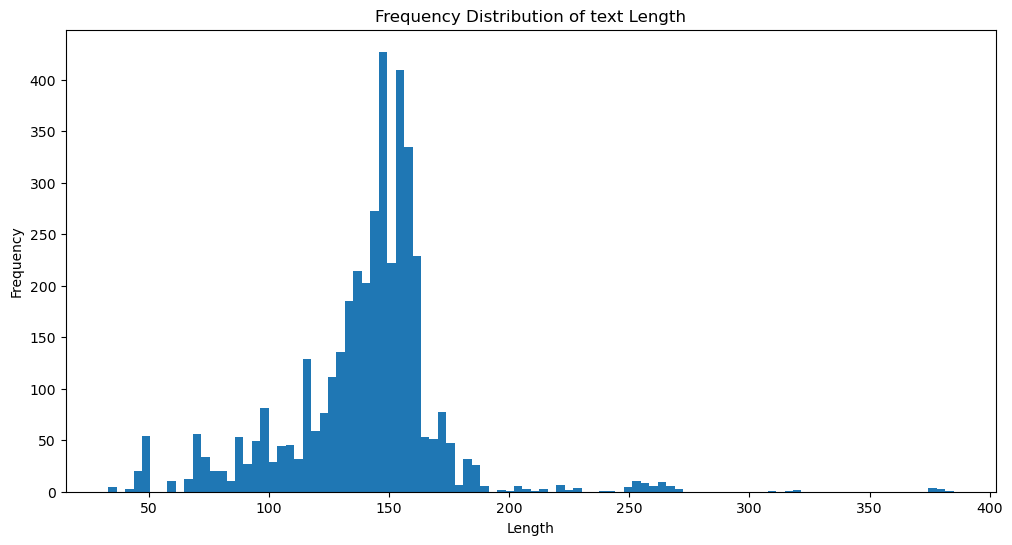

In [68]:
plot_text_length_histogram(phishing)

In [69]:
phishing['length'].describe()

count    4000.000000
mean      140.197250
std        33.088488
min        33.000000
25%       129.000000
50%       146.000000
75%       156.000000
max       385.000000
Name: length, dtype: float64

The text length distribution for phishing scam messages shows a broader and more varied spreadsuggesting more diverse messaging structures and greater attempt at realism.

The average message length is approximately 140 characters and Standard deviation is **33.09**, indicating a **moderate level of variation** — phishing messages vary more widely in size than crypto scams, which had very tight length clustering.

---

The shortest phishing message is **33 characters**, while the longest stretches to **385 characters** — unusually high for SMS.
This suggests **two-layered phishing strategy**:
  - Short urgent alerts
  - Longer advisory or procedural messages like maybe simulating banking procedures, payment flows, or security verifications.

---

Majority of messages (25th–75th percentile) fall between **129 to 156 characters**, tightly centered around standard SMS length.
Sharp peaks around **140–150 characters**.
Sparse but visible clusters exist at **>200 characters** . Outliers indicate adaptive scam design.


# Text Preprocess

In [70]:
phishing['tokens'] = phishing['text'].apply(text_preprocess)

In [71]:
print("Total Text Messages:", len(phishing))
print("Sample tokenized Messages:\n", phishing['tokens'].iloc[0])

Total Text Messages: 4000
Sample tokenized Messages:
 ['private', 'account', 'statement', 'shows', 'unredeemed', 'bonus', 'points', 'claim', 'call', 'identifier', 'code', 'expires']


# WordCloud

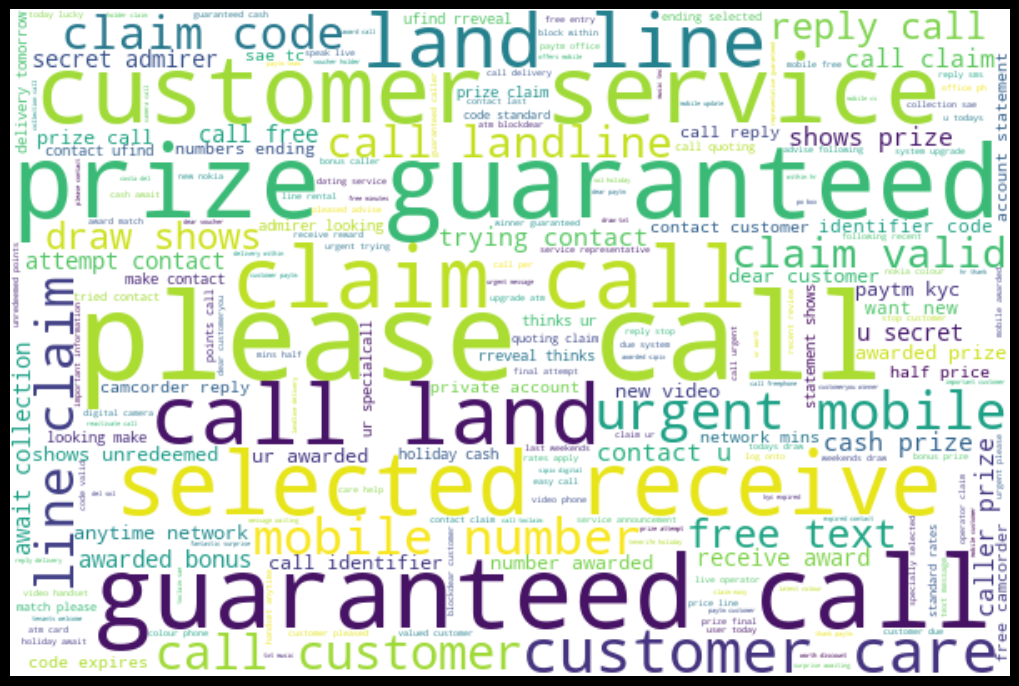

Top 10 frequent words are :

call        2550
claim       1015
prize        920
free         831
customer     829
mobile       680
u            647
contact      637
please       589
urgent       560
Name: count, dtype: int64


In [72]:
plot_wordcloud(phishing, tokens_column='tokens')

`"call"` dominates overwhelmingly (2,550 times), far more than any other word.
Other high-frequency terms like `"contact"`, `"mobile"`, `"customer"`, and `"service"` reinforce that phishing scams in SMS heavily **simulate customer service or official communication environments**.

Terms like `"claim"`, `"prize"`, `"free"`, and `"receive"` cluster heavily.
These words suggest that phishing messages often **promise unearned rewards** (free gifts, prizes, bonuses) as bait.
- However, unlike crypto scams (which emphasize "investment" and "returns"), phishing scams **frame rewards as already earned**, needing only simple action (like a call) to redeem.

`"urgent"` and `"please"` appear prominently softening the pressure but maintaining urgency.
- The polite tone combined with urgency (e.g., "please call immediately") **mimics real customer service escalation tones**, enhancing trust.

`"mobile"`, `"number"`, `"landline"`, and `"code"` suggest that phishing scams heavily involve references to phone numbers, verification codes, or contact procedures.




# Semantic Similarity Grouping

In [73]:
# Subset only top 300 messages to avoid graph overload
phishing_top = phishing.sample(n=300, random_state=42).reset_index(drop=True)


# Embed
phishing_embeddings = embed_sms_with_bert(phishing_top)

Loading model: all-MiniLM-L6-v2
Encoding 300 texts from column: 'text'


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [74]:
G = build_similarity_graph(similarity_matrix, phishing_top, threshold=0.82)

Building similarity graph (threshold > 0.82)...
Graph created with 300 nodes and 498 edges.


Plotting similarity graph WITH labels...


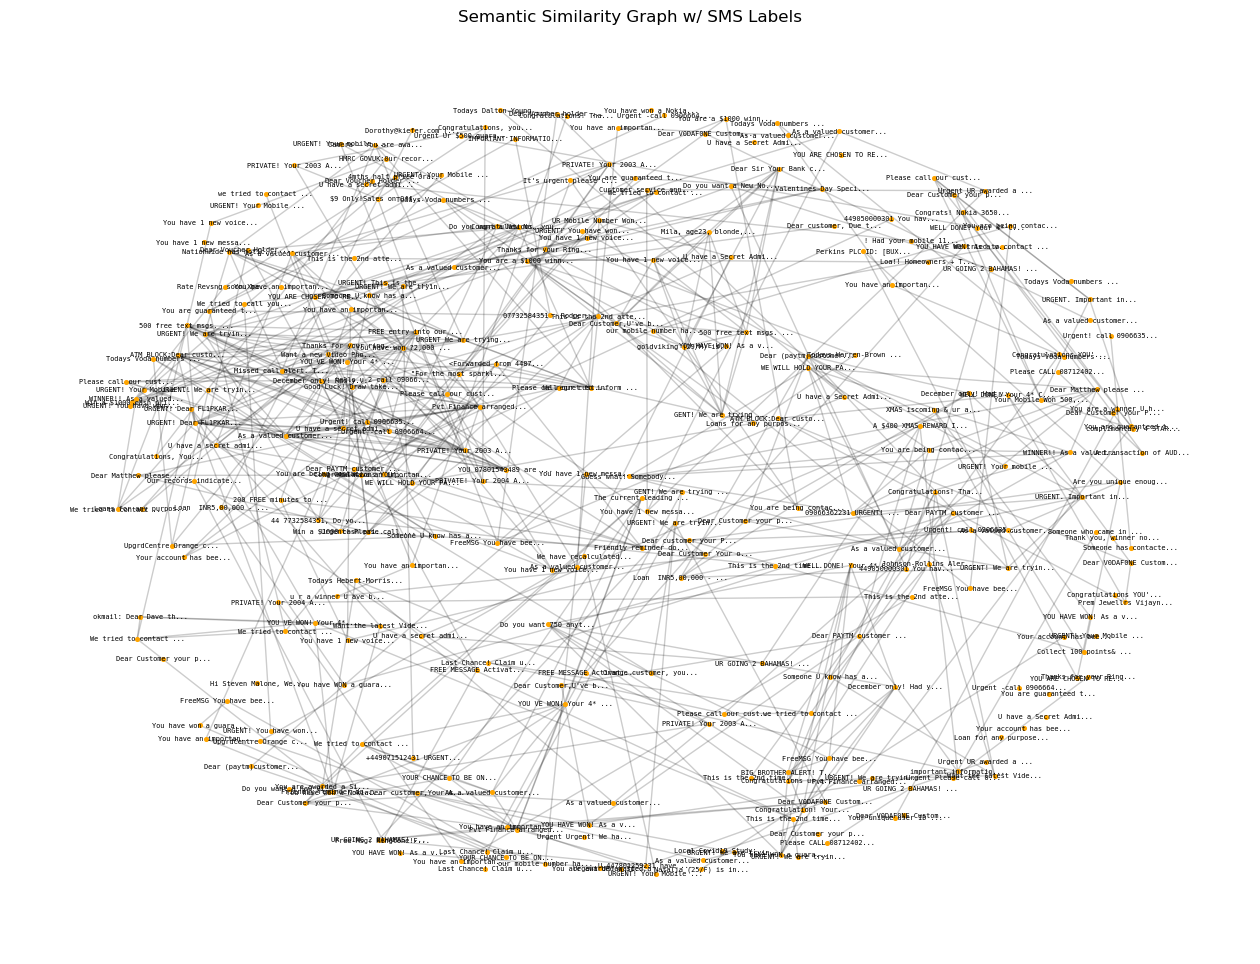

In [75]:
plot_similarity_graph_with_labels(G, phishing_top)

The graph shows a **dense interconnected core** with many strongly clustered nodes, surrounded by a **thinner spread of peripheral nodes**.
This suggests that a **significant portion** of phishing messages are **variations of a small number of central templates**, while a smaller set shows **creative or situational tailoring**.


Phishing scammers prefer **standardized templates for scalability**, but they allow **moderate customizations** when needed to bypass spam filters or better match specific targets.

---
Cluster 1 = Fake Customer Service Alerts 

Cluster 2 = Reward/Prize Claim Notifications 

Clusters show **distinct scam strategies**

---

While most messages inside clusters are semantically close 
There are some **meaningful phrasing variation**.
  - Changes in sender identity ("Dear Customer", "Your Bank", "Mobile Provider").
  - Changes in urgency ("URGENT", "Important Notice", "Final Reminder").
  - Slight differences in action requests ("Reply", "Call", "Verify").


Phishing templates are **modular** as the base structure remains, but fields like institution name, urgency level, and call-to-action verb are **dynamically adjusted** for freshness.

---

 
The semantic similarity graph confirms that phishing SMS scams are **moderately diversified, modular, and emotional-strategy split**.  
They maintain **tight template cores** but **allow controlled variations** to bypass filtering and also adapt to different scam scenarios.


# Bigrams

In [76]:
get_top_bigrams(phishing)

Top 10 Bigrams:
                bigram  frequency
0               00 000        317
3402  prize guaranteed        258
4389       valid 12hrs        215
3744  selected receive        198
2601         land line        194
1818     customer care        190
4351     urgent mobile        180
2648        line claim        174
2926     mobile number        173
1878     dear customer        171


bigram  frequency
0               00 000        317
3402  prize guaranteed        258
4389       valid 12hrs        215
3744  selected receive        198
2601         land line        194
...                ...        ...
2206     freemsg haven          1
1507        click link          1
1508        click list          1
1509        click main          1
3694      santos huber          1

[4708 rows x 2 columns]

The top bigrams in the phishing dataset reveal **structured communication strategies**, emphasizing **prize rewards**, **immediate urgency**,


---

`"land line"` (194 occurrences) and `"mobile number"` (173 occurrences) highlight a **heavy emphasis on traditional call-based contact**.
These bigrams reveal that phishing scams are **designed to shift victims onto voice channels**, away from traceable digital mediums.
we noticed that phishing attacks **deliberately avoid URLs or websites**, focusing instead on **direct human manipulation via calls**.

---

`"prize guaranteed"` (258) and `"selected receive"` (198) directly simulate **reward notifications**.

The framing here is **certainty-based** ("guaranteed", "selected") to bypass skepticism and encourage impulsive trust.

---

Phishing scams simulate **service environment interactions**,
The bigram analysis of phishing messages reveals a deliberate blending of reward excitement, service legitimacy to help  optimized to engineer immediate victim engagement



In [77]:
get_top_trigrams(phishing)

Top 10 Trigrams:
                    trigram  frequency
2946        land line claim        174
4283              rs 00 000        142
1622       claim 3030 valid        132
592        3030 valid 12hrs        132
2997        line claim 3030        127
5121   urgent mobile number        113
3352  mobile number awarded        111
2252         draw shows won        106
1897  contact customer care        100
2844             inr 00 000         98


trigram  frequency
2946                      land line claim        174
4283                            rs 00 000        142
1622                     claim 3030 valid        132
592                      3030 valid 12hrs        132
2997                      line claim 3030        127
...                                   ...        ...
2839   informationmain 2cibc mobileverify          1
634                       400 prize claim          1
2838  informationmain 2cibc mobilerefresh          1
2837   informationcategories search 2cibc          1
4537                         sms posts ww          1

[5550 rows x 2 columns]

In this dataset, trigram analysis **strengthens the conclusion** that scammers **rely on minimalistic message variation**.

The trigram analysis further exposes the rigid templating behavior behind phishing scam.

---

**8/10 (80%)** are **direct mechanical extensions** of top bigrams.
These simply **append minor verbs** like "claim", "awarded" or "number", without adding new scam strategy.

**80% of trigrams** are **not providing new scam structures** , they just extend action or contact framing around existing bigram skeletons.

---

The trigrams **do not reveal new scam styles** they just helpus to **confirm the template assembly mechanism** used in phishing SMS generation.


# TF-IDF

Top 10 words by TF-IDF score:
            word       score
1718       prize  140.757632
996     customer  140.088859
902        claim  136.103576
1153        free  124.787366
1487      mobile  106.731296
956      contact  105.501517
1            000   98.754102
2116      urgent   95.700035
1212  guaranteed   91.231206
2214         won   88.209862


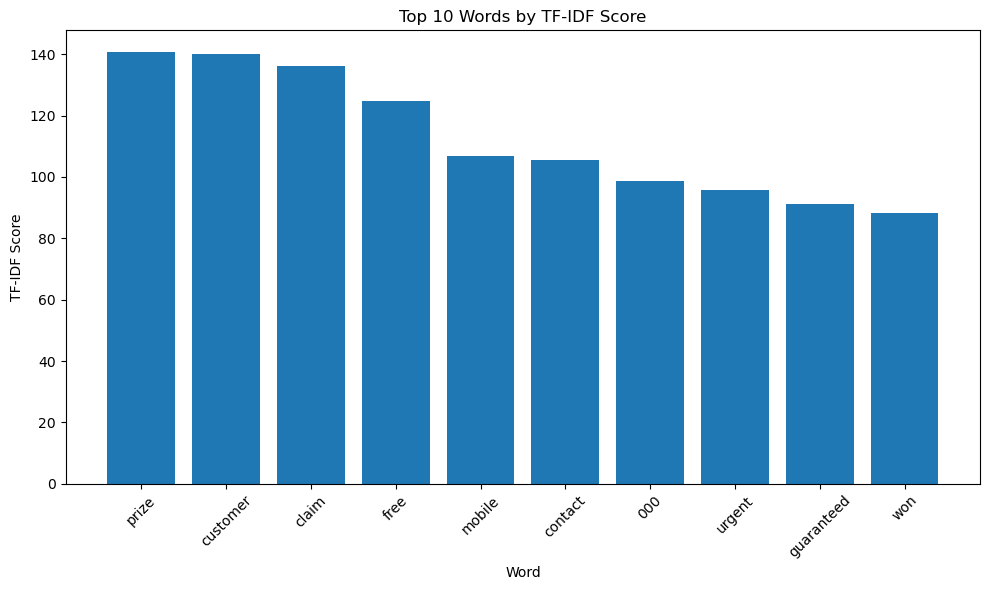

word       score
1718       prize  140.757632
996     customer  140.088859
902        claim  136.103576
1153        free  124.787366
1487      mobile  106.731296
...          ...         ...
1280         img    0.229966
2098      united    0.229966
1348     kingdom    0.229966
723   atcategory    0.222794
402      2change    0.218662

[2250 rows x 2 columns]

In [78]:
get_top_tfidf_words(phishing)



**Comparison with WordCloud and Frequency Analysis**

The TF-IDF results almost completely align with the earlier WordCloud findings.  
Words such as `"prize"`, `"customer"`, `"claim"`, `"free"`, `"mobile"`, `"contact"`, `"urgent"`, `"guaranteed"`, and `"won"` appear strongly in both analyses.

This tight overlap indicates that TF-IDF simply strengthens the signal, confirming that these words are not just common, but structurally significant across different scam message templates.

One slight difference is the word `"000"`, which surfaces more strongly in TF-IDF than in simple frequency analysis.  

---

**Comparison with Bigram and Trigram Structures**

The TF-IDF top words also closely reflect the n-gram patterns.  
Phrases like `"prize guaranteed"`, `"urgent mobile"`, `"customer care"`, and `"mobile number awarded"` seen in bigrams and trigrams are constructed precisely using the high TF-IDF words.

This shows that **scam tactics observed at the phrase level as they are anchored even at the single-word level**.  
Thus, TF-IDF provides **confirmation of scam template structure**.

No major new scam types or tactics are revealed by TF-IDF in this dataset.  

---
  
Detection pipelines can heavily leverage these repeated structural anchors for efficient filtering and classification, without worrying about unseen semantic drift at the word level.



# LDA TOPIC

In [79]:
display_lda_topics(phishing, num_topics=5, num_words=5, passes=10, random_state=42)

Topic: 0 
Words: 0.039*"free" + 0.038*"reply" + 0.034*"call" + 0.021*"phone" + 0.021*"video"
Topic: 1 
Words: 0.034*"call" + 0.029*"claim" + 0.022*"code" + 0.021*"ur" + 0.020*"selected"
Topic: 2 
Words: 0.060*"call" + 0.038*"urgent" + 0.036*"line" + 0.025*"number" + 0.024*"claim"
Topic: 3 
Words: 0.067*"call" + 0.027*"customer" + 0.023*"mobile" + 0.022*"u" + 0.017*"valued"
Topic: 4 
Words: 0.056*"call" + 0.055*"prize" + 0.039*"customer" + 0.033*"contact" + 0.032*"claim"


**Topic 0 – Free Offer and Multimedia Engagement Hooks**

this topic frames the scam around **reward excitement ("free")** combined with **action requests ("reply", "call")**, reinforcing impulsive behavior in victims.

---

**Topic 1 – Claim and Verification Procedures**

This group is framed around `"call"`, `"claim"`, `"code"`, `"ur"`, and `"selected"`.  
It strongly suggests phishing messages that simulate **reward claim verifications**

---

**Topic 2 – Urgent Call to Action and Hotline Emphasis**

Dominated by `"call"`, `"urgent"`, `"line"`, `"number"`, and `"claim"`, this topic clearly represents high-pressure scam variants**.


This reflects the classic phishing tactic of combining **fear and urgency** to bypass rational thinking and force rapid engagement.

---

**Topic 3 – Customer Care Impersonation**

This topic features `"call"`, `"customer"`, `"mobile"`, `"u"`, and `"valued"`.  
Here, phishing messages attempt to mimic legitimate customer service communication 

---

**Topic 4 – Prize Redemption Communication**

this topic focuses on formal reward collection narratives.  


---

**Overall Observations on Topic Structure**

the topics overlap significantly as almost every topic revolves around a `"call"` action.
Moreover, themes of `"free"`, `"prize"`, `"claim"`, and `"urgent"` cycle across topics with only minor shifts in phrasing.

This heavy thematic overlap suggests that while scammers modularly vary message details, they rarely deviate from the core goal.

---

This Phishing SMS scams operate through **narrow thematic framing**, with extremely limited semantic creativity.  



# Ham Datatset

In [80]:
ham = ham.drop(columns=['URL', 'EMAIL', 'PHONE'])

In [81]:
ham.rename(columns={'TEXT': 'text', 'LABEL': 'label'}, inplace=True)

In [82]:
ham = ham[ham['label'] == 'ham'].copy()


In [83]:
print("Ham DataFrame:")
print(ham.head())
print(ham.info())

Ham DataFrame:
  label                                               text
0   ham  Your opinion about me? 1. Over 2. Jada 3. Kusr...
1   ham  What's up? Do you want me to come online? If y...
2   ham                       So u workin overtime nigpun?
3   ham  Also sir, i sent you an email about how to log...
6   ham  Sorry dude. Dont know how i forgot. Even after...
<class 'pandas.core.frame.DataFrame'>
Index: 4844 entries, 0 to 5970
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4844 non-null   object
 1   text    4844 non-null   object
dtypes: object(2)
memory usage: 113.5+ KB
None


In [84]:
ham = ham.drop(columns=['label'])

In [85]:
print("Ham DataFrame:")
print(ham.head())
print(ham.info())

Ham DataFrame:
                                                text
0  Your opinion about me? 1. Over 2. Jada 3. Kusr...
1  What's up? Do you want me to come online? If y...
2                       So u workin overtime nigpun?
3  Also sir, i sent you an email about how to log...
6  Sorry dude. Dont know how i forgot. Even after...
<class 'pandas.core.frame.DataFrame'>
Index: 4844 entries, 0 to 5970
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4844 non-null   object
dtypes: object(1)
memory usage: 75.7+ KB
None


In [86]:
ham['length'] = ham['text'].apply(len)
ham.head()

text  length
0  Your opinion about me? 1. Over 2. Jada 3. Kusr...     136
1  What's up? Do you want me to come online? If y...      79
2                       So u workin overtime nigpun?      28
3  Also sir, i sent you an email about how to log...     173
6  Sorry dude. Dont know how i forgot. Even after...      93

# Text Length Distribution

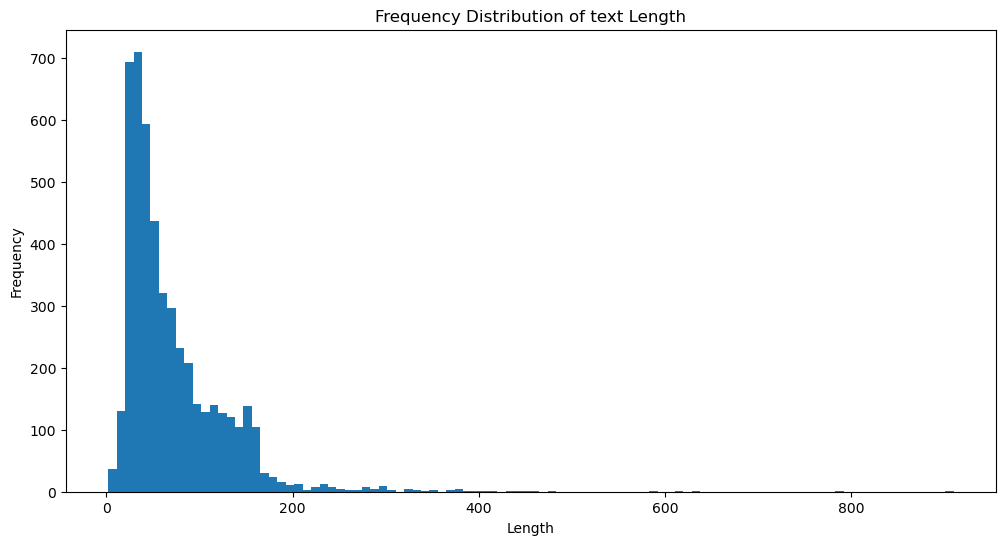

In [87]:
plot_text_length_histogram(ham)

In [88]:
ham['length'].describe()

count    4844.000000
mean       70.704583
std        56.154333
min         2.000000
25%        34.000000
50%        53.000000
75%        91.000000
max       910.000000
Name: length, dtype: float64


This HAM dataset exhibits a **much wider and more natural variation** in message lengths compared to any scam category.  
Lengths range from **as short as 2 characters** to **over 910 characters**, indicating a full range of real-world usage patterns.

In contrast, scam datasets (phishing, crypto, financial) had **tighter length bands**, usually clustering narrowly around optimized emotional triggers (around 60–140 characters).  
Real communication, by contrast, reflects much more **diverse user intent**, including casual texts, detailed updates, and even multi-paragraph messages.

---

The average message length is approximately **70 characters**, with the 25th to 75th percentile range spanning from about **34 to 91 characters**.  
This fits naturally within expected norms of **daily mobile communication** — short, informal, and variable in length.


---
In the HAM dataset, the distribution shows a **natural decline** like no unnatural clustering at any specific length, but rather a **gradual taper** with a long tail.

This "long tail" behavior is **highly indicative of authentic user-generated communication**.

---
  
The HAM SMS dataset demonstrates a **natural, diverse, and richly variable communication pattern**.

This reinforces the need for **smart semantic features** rather than **naive statistical filters** when distinguishing real messages from scams in production detection systems.



# Text Preprocess

In [89]:
ham['tokens'] = ham['text'].apply(text_preprocess)

In [90]:
print("Total Text Messages:", len(ham))
print("Sample tokenized Messages:\n", ham['tokens'].iloc[0])

Total Text Messages: 4844
Sample tokenized Messages:
 ['opinion', 'jada', 'kusruthi', 'lovable', 'silent', 'spl', 'character', 'matured', 'stylish', 'simple', 'pls', 'reply']


# WordCloud

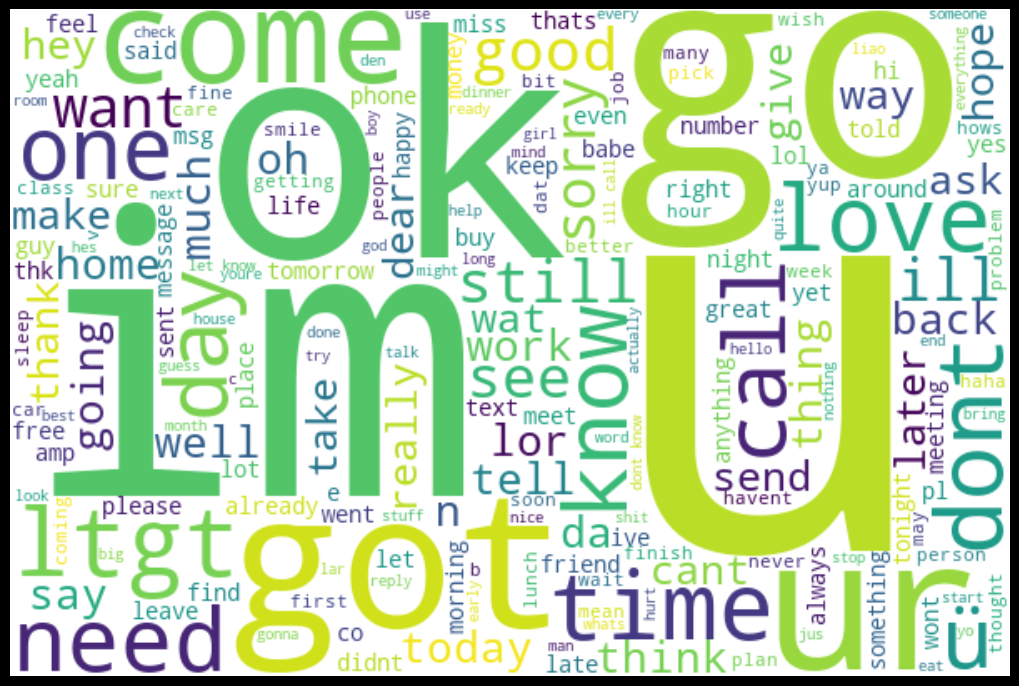

Top 10 frequent words are :

u       999
im      450
get     298
dont    270
ok      259
go      253
ur      244
ltgt    238
know    236
got     230
Name: count, dtype: int64


In [91]:
plot_wordcloud(ham, tokens_column='tokens')


The most frequent words are extremely **informal, short, and conversational**.  
Words like `"u"`, `"im"`, `"get"`, `"dont"`..., dominate the communication landscape.

These words are typical of **casual, rapid texting behavior**,

---

Heavy Usage of Abbreviations and Slang

The appearance of `"u"`, `"im"`, `"ur"`, and `"ltgt"` indicates a strong reliance on **shorthand texting**.

This is highly characteristic of **authentic mobile communication**, especially from earlier generations of SMS where typing efficiency was critical.  

There is a **clear personal tone** in real SMS exchanges

---

The high presence of simple verbs like `"go"`, `"get"`, `"know"`, `"want"`, `"make"`, `"call"` suggests that real conversations **rely on shared context**.  

These words alone are meaningless without the recipient knowing the full situation ("I'll get it later", "Do you know where", "Call me when you can").

This contrasts sharply with scam messages, which are **self-contained**, **fully explanatory**, and designed for **one-shot action** even without prior knowledge.

Real SMS communication **assumes prior shared understanding** — scam SMS **assumes none** and builds full context inside a single message.

---

From a detection modeling standpoint, this suggests that real messages have high entropy.

The HAM dataset's word usage reflects authentic human conversation

 - * training mdoel on **n-gram sophistication**, **semantic density**, and **contextual intent detection** can differentiate between real and scam SMS with higher precision ( future improvements)


# Semantic Similarity Grouping

In [92]:
# Subset only top 300 messages to avoid graph overload
ham_top = ham.sample(n=300, random_state=42).reset_index(drop=True)


# Embed
ham_embeddings = embed_sms_with_bert(ham_top)

Loading model: all-MiniLM-L6-v2
Encoding 300 texts from column: 'text'


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [93]:
G = build_similarity_graph(similarity_matrix, ham_top, threshold=0.82)

Building similarity graph (threshold > 0.82)...
Graph created with 300 nodes and 498 edges.


Plotting similarity graph WITH labels...


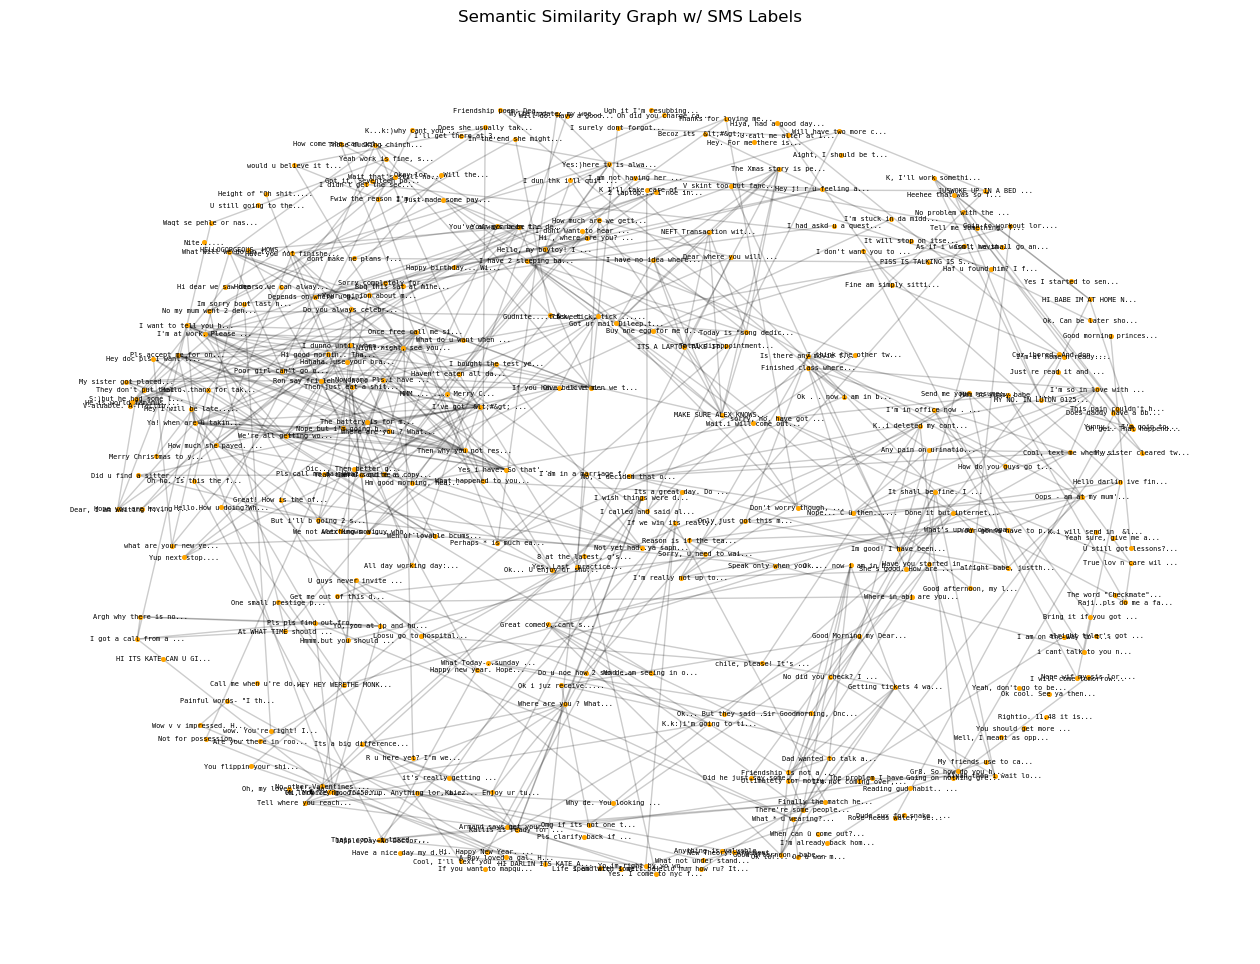

In [94]:
plot_similarity_graph_with_labels(G, ham_top)

The HAM semantic map displays a **wide scattering of small, weakly connected clusters** 

Messages group into small islands based on broad thematic similarities,— but **there is no overarching template architecture** holding them together.
  
---

**Low Semantic Redundancy**

Unlike scam graphs — where messages were heavily overlapped because templates were reused with minor changes — the HAM messages show **semantic uniqueness** even when talking about similar things.  


---

**No Strong Central Anchors**

the HAM graph has **no dominant anchor points**.  
Even frequent words like `"ok"`, `"u"`, `"im"`, `"call"`, `"love"` are **spread out across many contexts**, not concentrating into singular hubs.

Authentic SMS communication is **context-sensitive** as words derive meaning only relative to broader conversation history, not stand-alone action commands.

---

From a technical perspective,  real SMS datasets cannot be easily compressed or clustered into tight semantic groups

Detection models should be cautious when over-compressing real user datasets, as it risks collapsing genuine variability into false positives.



# Bigrams

In [95]:
get_top_bigrams(ham)

Top 10 Bigrams:
             bigram  frequency
12174         lt gt        238
11075      let know         42
11556      ll later         32
7458   good morning         32
18283      sorry ll         30
5042       don know         24
13836      new year         23
14382        ok lor         22
10136      just got         20
7775      great day         19


bigram  frequency
12174         lt gt        238
11075      let know         42
11556      ll later         32
7458   good morning         32
18283      sorry ll         30
...             ...        ...
8220       half day          1
8219    half chores          1
8218       half buy          1
8217       half 8th          1
23363   〨ud evening          1

[23364 rows x 2 columns]


Phrases like `"let know"`, `"ll later"`, `"good morning"`, `"sorry ll"`, `"don know"`, and `"just got"` are all **snippets of everyday personal conversation**, not transaction-oriented communication.


Real SMS communication consists of fragmented exchanges, heavily reliant on previous shared understanding between sender and receiver.

---

From a detection modeling perspective, this suggests that scam detection should not overly penalize short, casual, or emotionally lightweight phrases because in real-world SMS, these are the norm rather than the exception.

Models should instead focus on detecting **structured urgency**, **action-heavy bigrams**, and **transactional language clusters**, which are rare in legitimate texting.



In [96]:
get_top_trigrams(ham)

Top 10 Trigrams:
                trigram  frequency
17318    sorry ll later         28
7804     happy new year         17
10700        like lt gt         14
11580     lt decimal gt         14
11643          lt gt lt         12
14478  pick phone right         12
8283           hi hi hi         11
7391           gt lt gt         11
11646         lt gt min         10
4678      don want talk          8


trigram  frequency
17318      sorry ll later         28
7804       happy new year         17
10700          like lt gt         14
11580       lt decimal gt         14
11643            lt gt lt         12
...                   ...        ...
7539   guy paranoid doesn          1
7538    guy met walkabout          1
7537         guy met town          1
7536   guy know breathing          1
22008       zyada kisi ko          1

[22009 rows x 2 columns]

**Trigram Frequency Analysis**

The trigram distribution in the HAM dataset further highlights the **messy, creative, and emotional nature** of real human texting —  
and provides critical contrast against the **highly structured templates** found in scam communications.

This shows that **60%** of the most frequent trigrams are **direct extensions** of ideas already present in bigrams.  
They **do not reveal fundamentally new messaging strategies**.


The trigram distribution in HAM SMS communication showcases **the depth, imperfection, and social fabric of real human interactions** —  
a world away from the **polished, optimized, single-intent chains** found in scam SMS datasets.  
Detection systems must embrace this complexity rather than flattening it through overly rigid rule-based approaches.



# TF-IDF

Top 10 words by TF-IDF score:
      word      score
4056    ok  92.724363
3389    ll  70.726757
1244  come  66.200862
3115  just  63.605084
2450  good  60.409688
3196  know  57.046749
3472    lt  55.287699
2527    gt  55.274273
5907  time  54.464531
2731  home  53.647226


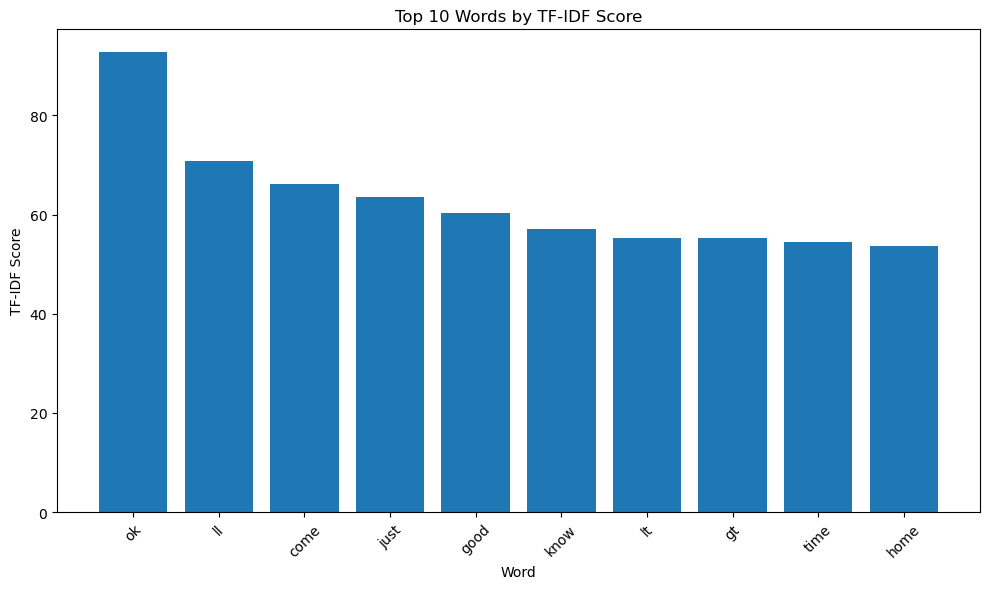

word      score
4056            ok  92.724363
3389            ll  70.726757
1244          come  66.200862
3115          just  63.605084
2450          good  60.409688
...            ...        ...
1600    determined   0.075884
1260     companion   0.075884
4304          pest   0.075884
4593       pudunga   0.075884
2039  exterminator   0.075884

[6640 rows x 2 columns]

In [97]:
get_top_tfidf_words(ham)

Interestingly, `"lt"` and `"gt"` noisey tokens also appear in the top TF-IDF scores.  
These are artifacts from HTML encoding issues during preprocessing and have **no semantic contribution**.

Real-world datasets, even HAM, **carry technical noise**.  
TF-IDF **lifts noise** when it is frequent enough, underlining the need for careful **pre-cleaning** in production-grade pipelines.


In [98]:
display_lda_topics(ham, num_topics=5, num_words=5, passes=10, random_state=42)

Topic: 0 
Words: 0.059*"u" + 0.019*"ok" + 0.018*"go" + 0.015*"lor" + 0.013*"ü"
Topic: 1 
Words: 0.018*"dont" + 0.012*"know" + 0.011*"got" + 0.010*"like" + 0.009*"thats"
Topic: 2 
Words: 0.022*"im" + 0.013*"well" + 0.012*"get" + 0.009*"hi" + 0.009*"back"
Topic: 3 
Words: 0.031*"u" + 0.020*"love" + 0.019*"ur" + 0.015*"good" + 0.013*"day"
Topic: 4 
Words: 0.016*"ltgt" + 0.010*"im" + 0.008*"get" + 0.007*"yes" + 0.006*"see"


The word `"u"` dominates both Topic 0 and Topic 3, `"im"` appears in Topics 2 and 4, and `"get"` repeats across several topics.  
There is **no clean separation** as real conversations weave through emotions, logistics, affirmations fluidly, not in clean blocks.

In real SMS data, LDA modeling will **not yield sharp, discriminative themes**

# UNION ALL

To unify all scam and non-scam datasets for subsequent modeling,  
we explicitly assign a unique label to each dataset before concatenation.

The label assignment is as follows:
- E-commerce Scams (`ecom`) → Label `1`
- Financial Scams (`fin`) → Label `2`
- Cryptocurrency Scams (`crypto`) → Label `3`
- Phishing Scams (`phishing`) → Label `4`
- HAM (Non-Scam Legitimate Messages) (`ham`) → Label `0`


In [99]:
ecom['label'] = 1
fin['label'] = 2
crypto['label'] = 3
phishing['label'] = 4
ham['label'] = 0

In [100]:
df = pd.concat([
    ecom[['text','label']], 
    fin[['text','label']], 
    crypto[['text','label']], 
    phishing[['text','label']], 
    ham[['text','label']]
], ignore_index=True)

In [101]:
print(df.head())
print(df.info())

                                                text  label
0  AliExpress update: Your package #ORD2UQGY7 is ...      1
1  SG Amazon Alert: You won a reward! Claim here:...      1
2  Taobao update: Your package #ORDOM9D4U is unde...      1
3  Amazon - Order #ELIP3R is on hold. Verify ship...      1
4  Action Required: Shopee delivery could not be ...      1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20844 entries, 0 to 20843
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20844 non-null  object
 1   label   20844 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 325.8+ KB
None


In [102]:
df.to_csv("df.csv", index=False)

<!-- Signature: Jyoshika Barathimogan -->
